In [1]:
import sncosmo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sncosmo.salt2utils import BicubicInterpolator
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
import pickle as pk
from matplotlib.backends.backend_pdf import PdfPages
import os 
from matplotlib.offsetbox import AnchoredText
import astropy.constants as const
import astropy.units as u
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

H_ERG_S = const.h.cgs.value
C_AA_PER_S = const.c.to(u.AA / u.s).value
HC_ERG_AA = H_ERG_S * C_AA_PER_S
SCALE_FACTOR = 1e-12

In [2]:
class ScalarFormatterClass1(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

## Comentários

In [3]:
#

## Recuperando curvas de luz

In [4]:
path="/home/cassia/SNANA/snroot/lcmerge/SDSS_allCandidates+BOSS/"

In [5]:
sne_sdss_pan=pd.read_csv("sdss_pantheon.txt",header=None,dtype=str)

In [6]:
sne_list=np.array(sne_sdss_pan).T[0]

In [7]:
path_filters="/home/cassia/SNANA/snroot/filters/PS1/Pantheon/SDSS_Doi2010/CCDAVG/"

## Registrando filtros e criando sistema de magnitude composto

In [8]:
ab = sncosmo.get_magsystem('ab')

In [9]:
for filt in ["U","G","R","I","Z"]:
    wave = pd.read_csv(path_filters+filt+".dat",header=None,sep="\s+",comment="#")[0].values
    trans = pd.read_csv(path_filters+filt+".dat",header=None,sep="\s+",comment="#")[1].values
    band = sncosmo.Bandpass(wave, trans, name='SDSS_'+filt,trim_level=0.05)
        
    sncosmo.registry.register(band)

In [10]:
magsystem = {"SDSS_U":('ab',0.00000),
             "SDSS_G":('ab',-0.0073-0.0029473880),
             "SDSS_R":('ab',-0.0088+0.0044133478),
             "SDSS_I":('ab',-0.0090+0.00072395845),
             "SDSS_Z":('ab',-0.0094-0.0083579659)}

In [11]:
magsys = sncosmo.CompositeMagSystem(bands=magsystem,name="magsys")

In [12]:
# f=10**(-0.4m+0.4Z)

In [13]:
# m=-2.5*log10(flux)+Z

In [14]:
# FCAL=10**(-0.4m+11)

## Criando modelo EXP

In [15]:
class EXP_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2']
    param_names_latex = ['x_0', 'x_1', 'x_2']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0.T)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1.T)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2.T)

        self._parameters = np.array([1, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2= self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave))

In [16]:
gridx2 = np.linspace(-10, 50, 50+10+1, dtype=int)
gridy2 = np.linspace(3400, 8400, int((8400-3400)/10+1), dtype=int)

In [17]:
X, Y = np.meshgrid(gridx2,gridy2)

#### Templates FA

In [18]:
M_fa=[]
for i in range(3):
    M_fa.append(np.loadtxt("../fa/sk_quartimax_M"+str(i)+".txt")*SCALE_FACTOR)

#### Templates PCA

In [19]:
M_pca=[]
for i in range(3):
    M_pca.append(np.loadtxt("../pca/M"+str(i)+"_pca.txt")*SCALE_FACTOR)

### Criando os modelos

In [20]:
exp_fa = EXP_LC(gridx2, gridy2, M_fa[0], M_fa[1], M_fa[2])
exp_pca = EXP_LC(gridx2, gridy2, M_pca[0], M_pca[1], M_pca[2])

In [21]:
sncosmo.register(exp_fa,name="exp_fa_quartimax")
sncosmo.register(exp_pca,name="exp_pca")

## Escolha do modelo

In [22]:
modelo="exp_fa_quartimax"

## Ajustando curvas de luz

In [23]:
def lc_fit(sn):    
    try:
        dat = sncosmo.read_snana_fits(path+"SDSS_allCandidates+BOSS_HEAD.FITS",path+"SDSS_allCandidates+BOSS_PHOT.FITS",snids=[str(sn).encode('UTF-8')])[0]
    except:
        print(f"File not found for SN {sn}")
        return None
        
    meta = dat.meta
    
    surv="SDSS"

    dat.add_column([surv+"_"+f.upper() for f in dat["FLT"]], name='FILTER') # decodificando
    dat.remove_column("FLT")
      
    dat.remove_rows(np.where(dat["FLUXCAL"]<0)[0])
    dat.remove_rows(np.where(np.isnan(dat["MAG"]))[0])

    magsys=sncosmo.CompositeMagSystem(bands=magsystem,name="magsys")
    sncosmo.register(magsys,force=True)

    dat["FLUX"]=[magsys.band_mag_to_flux(dat["MAG"][i],dat["FILTER"][i]) for i in range(len(dat["MAG"]))]
    dat["FLUXERR"]=[abs(0.4*dat["FLUX"][i]*np.log(10.)*dat["MAGERR"][i]) for i in range(len(dat["MAG"]))]
    dat.remove_columns(["FIELD","TELESCOPE","PHOTFLAG","PHOTPROB","MAG","MAGERR","ZEROPT","ZEROPT_ERR"])

    dat.remove_rows(np.where(dat["FLUX"]/dat["FLUXERR"]<5)[0])
                             
    # ref de repouso: (t-t0)/(1+z), no SNANA fazem um corte de -15 a 45 no referencial de repouso. E também tem um corte no 
    # intervalo de comprimento de onda, eu apliquei esses cortes abaixo em phase_range e wave_range. Porém não tenho certeza
    # se o sncosmo corta no ref de repouso ou do observador. Alterando isso, os valores de x1 para 2001ah e 2001az mudam drasticamento
    # equivalendo a mesma mudança que ocorre no snana quando fazemos a mesma alteração no TREST_REJECT.    
    if sn in ["20088","15465","15440","14984"]:
            dat.remove_rows(np.where(dat["FILTER"]==surv+"_R")[0])
    
    if sn in ["19968","14989","7475","20088","18617","18241","17552","17784","17809",
              "17240","15465","15440","15161","13136","12883","4679","1241","14984"]:
            dat.remove_rows(np.where(dat["FILTER"]==surv+"_I")[0])

    dat.remove_rows(np.where(dat["FILTER"]==surv+"_Z")[0])

    dat["ZP"]=[2.5*np.log10(magsys.zpbandflux(f)) for f in dat["FILTER"]]
    dat.add_column("magsys", name='ZPSYS')
    
    dust = sncosmo.F99Dust() 

    # para algumas sne como 2006bb o chi2 da minimizacao da Nan e não é possível ajustar a sn. A mesma sn no snana é ajustada pelo salt.
    # alterando intervalo de dias e comprimento de onda de atuação do ajustador, ainda não é possível evitar o nan já no primeiro passo.
    
    model = sncosmo.Model(source=modelo,effects=[dust],effect_names=['mw'],effect_frames=['obs'])
    model.set(z=meta["REDSHIFT_FINAL"],mwebv=meta["MWEBV"]) 

    try:
        result, fitted_model = sncosmo.fit_lc(dat, model, ['t0', 'x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 40.), wave_range=(3400.,7000.), verbose=False)
        #bounds={"t0":(meta["PEAKMJD"]-10,meta["PEAKMJD"]+10)}
    except:
        print(f"SN {sn} fit returns NaN")
        result=None
        fitted_model=None
    
    return meta, surv, dat, result, fitted_model

In [24]:
pp = PdfPages(f"./lc_fit_plot_{modelo.upper()}_SDSS_Pantheon.pdf")

In [25]:
colors1=["#440154"]
colors2=["#fde725","#440154"]
colors3=["#fde725","#21918c","#440154"]
colors4=["#fde725","#35b779","#31688e","#440154"]

In [26]:
def lc_fit_plot(sn, surv,table_data, result, fitted_model):
    z=round(result["parameters"][0],2)
    t0=round(result["parameters"][1],2)
    x1=round(result["parameters"][3],2)
    x1err=round(result["errors"]["x1"],2)
    x2=round(result["parameters"][4],2)
    x2err=round(result["errors"]["x2"],2)
    mwebv=result["parameters"][5]
    phase=np.linspace(t0-10.,t0+50.,100)

    if result.ndof>0:
        fil=[]
        for i,f in enumerate(magsystem.keys()): 
            if len(table_data[table_data["FILTER"]==f])==0:
                continue
            else:
                try:
                    fitted_model.bandflux(f, phase)
                    fil.append(f)
                    continue
                except:
                    continue
        fig, axs=plt.subplots(len(fil),1,figsize=(10,4*len(fil)),sharex=True)
        fig.subplots_adjust(hspace=0.1)
        if len(fil)==1:
            for i,f in enumerate(fil): 
                colors=eval("colors"+str(len(fil)))
                axs.plot(phase-t0,fitted_model.bandflux(f, phase)*10**(-0.4*table_data[table_data["FILTER"]==f]["ZP"][0]+11),linewidth=3,color=colors[i],label=f"{modelo.upper()} fit ($\chi^2/ndof$={round(result.chisq/result.ndof,2)})")
                axs.errorbar(table_data[table_data["FILTER"]==f]["MJD"]-t0,table_data[table_data["FILTER"]==f]["FLUXCAL"],yerr=table_data[table_data["FILTER"]==f]["FLUXCALERR"],label=f"Flux through {f} filter",ls="none", marker='o',markersize=8,color=colors[i])
                axs.set_ylabel(r"FLUX ($Z_{AB}$=27.5)")
                axs.set_xlim(-12,52)
                axs.set_title(f"{sn}({surv}),   z:{z:.2f},   x1={x1:.2f}$\pm${x1err:.2f},   x2={x2:.2f}$\pm${x2err:.2f}")
                formatter11=ScalarFormatterClass1()
                formatter11.set_scientific(True)
                formatter11.set_powerlimits((0,0))
                axs.yaxis.set_major_formatter(formatter11)
                axs.legend(loc=3)
                if i==len(fil)-1:
                    axs.set_xlabel(f"MJD-{t0}")
            #plt.show()
            plt.tight_layout()
            pp.savefig()
            plt.close(fig)
        else:
            for i,f in enumerate(fil): 
                colors=eval("colors"+str(len(fil)))
                axs[i].plot(phase-t0,fitted_model.bandflux(f, phase)*10**(-0.4*table_data[table_data["FILTER"]==f]["ZP"][0]+11),linewidth=3,color=colors[i],label=f"{modelo.upper()} fit ($\chi^2/ndof$={round(result.chisq/result.ndof,2)})")
                axs[i].errorbar(table_data[table_data["FILTER"]==f]["MJD"]-t0,table_data[table_data["FILTER"]==f]["FLUXCAL"],yerr=table_data[table_data["FILTER"]==f]["FLUXCALERR"],label=f"Flux through {f} filter",ls="none", marker='o',markersize=8,color=colors[i])
                axs[i].set_ylabel(r"FLUX ($Z_{AB}$=27.5)")
                axs[i].set_xlim(-12,52)
                axs[i].set_title(f"{sn}({surv}),   z:{z:.2f},   x1={x1:.2f}$\pm${x1err:.2f},   x2={x2:.2f}$\pm${x2err:.2f}")
                formatter11=ScalarFormatterClass1()
                formatter11.set_scientific(True)
                formatter11.set_powerlimits((0,0))
                axs[i].yaxis.set_major_formatter(formatter11)
                axs[i].legend(loc=3)
                if i==len(fil)-1:
                    axs[i].set_xlabel(f"MJD-{t0}")
            #plt.show()
            plt.tight_layout()
            pp.savefig()
            plt.close(fig)
    else:
        pass

In [27]:
 def return_fit_data(sn,meta,res,model_name):
    return [sn, "SDSS", meta["REDSHIFT_FINAL"], 0., res.parameters[1],
           res.errors["t0"], res.parameters[2], res.errors["x0"], res.parameters[3],
           res.errors["x1"], res.parameters[4], res.errors["x2"],
           res.covariance[1][2], res.covariance[1][3], res.covariance[2][3], 
           res.chisq/res.ndof, model_name]

In [28]:
all_fit_data=[]
f=open(f"./lc_failed_fits_{modelo.upper()}_SDSS_Pantheon.txt","w")
for j,sn in enumerate(sne_list):
    print(sn, f"({j}/{len(sne_list)})")

    if lc_fit(sn)== None:
        f.write(f"File not found for SN {sn}")
        continue
        
    meta, surv, table_data, result, fitted_model=lc_fit(sn) 

    if result is None:
        f.write(f"SN {sn} fit returns NaN\n")
        continue
    else:
        if result.success and result.ndof>0:
            all_fit_data.append(return_fit_data(sn,meta,result,f"{modelo.upper()}"))
        elif result.success and result.ndof==0:
            f.write("ndof 0 for SN"+sn+"\n")
            continue
        elif not result.success:
            f.write("Unsuccessful fit of SN"+sn+"\n")
            continue
    
    lc_fit_plot(sn, surv, table_data, result, fitted_model)                       

744 (0/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1112 (1/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1241 (2/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1371 (3/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1580 (4/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1794 (5/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2031 (6/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2102 (7/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2165 (8/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2422 (9/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2635 (10/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2689 (11/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2916 (12/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2992 (13/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3080 (14/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3087 (15/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3317 (16/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3377 (17/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3451 (18/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


4046 (19/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


4241 (20/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


4679 (21/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5103 (22/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5533 (23/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5549 (24/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5635 (25/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5957 (26/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5994 (27/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6057 (28/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6108 (29/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6196 (30/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6315 (31/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6422 (32/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6558 (33/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6924 (34/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7147 (35/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7243 (36/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7779 (37/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7847 (38/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


8495 (39/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


8921 (40/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


9032 (41/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


9457 (42/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


9467 (43/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12779 (44/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12781 (45/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12856 (46/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12881 (47/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12883 (48/337)
12898 (49/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(ou

12927 (50/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12950 (51/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12972 (52/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13005 (53/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13038 (54/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13044 (55/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13136 (56/337)
13152 (57/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, S

13254 (58/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13411 (59/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13578 (60/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13610 (61/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13689 (62/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13736 (63/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13796 (64/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14019 (65/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14024 (66/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14108 (67/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14331 (68/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14397 (69/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14421 (70/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14451 (71/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14735 (72/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14871 (73/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14979 (74/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15057 (75/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15129 (76/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15161 (77/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15213 (78/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15219 (79/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15234 (80/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15259 (81/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15287 (82/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15301 (83/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15354 (84/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15383 (85/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15421 (86/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15440 (87/337)
SN 15440 fit returns NaN
SN 15440 fit returns NaN
15443 (88/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15456 (89/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15461 (90/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15467 (91/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15583 (92/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15776 (93/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15868 (94/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15901 (95/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16021 (96/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16032 (97/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16073 (98/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16093 (99/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16099 (100/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16106 (101/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16116 (102/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16165 (103/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16206 (104/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16211 (105/337)
16213 (106/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(ou

16281 (107/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17168 (108/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17215 (109/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17218 (110/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17220 (111/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17240 (112/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17366 (113/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17389 (114/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17464 (115/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17497 (116/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17552 (117/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17784 (118/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17791 (119/337)
17809 (120/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(ou

17811 (121/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17825 (122/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17875 (123/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17884 (124/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18030 (125/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18241 (126/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18323 (127/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18325 (128/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18466 (129/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18486 (130/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18602 (131/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18617 (132/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18697 (133/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18721 (134/337)
18749 (135/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(ou

18804 (136/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18809 (137/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18835 (138/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(ou

18855 (139/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18927 (140/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18940 (141/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18945 (142/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18965 (143/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19002 (144/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19023 (145/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19027 (146/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19067 (147/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19128 (148/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19230 (149/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19282 (150/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19341 (151/337)
19353 (152/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, S

19425 (153/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19596 (154/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19632 (155/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19775 (156/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19794 (157/337)
19818 (158/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(ou

19913 (159/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19953 (160/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19969 (161/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19990 (162/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20039 (163/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20084 (164/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20088 (165/337)
SN 20088 fit returns NaN
SN 20088 fit returns NaN
20111 (166/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20142 (167/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20227 (168/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20245 (169/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20364 (170/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20581 (171/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20687 (172/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21006 (173/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21033 (174/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21042 (175/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21062 (176/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21502 (177/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


722 (178/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


762 (179/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


774 (180/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1032 (181/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1253 (182/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2017 (183/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2246 (184/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2308 (185/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2330 (186/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2372 (187/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2440 (188/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2533 (189/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2561 (190/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2789 (191/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2943 (192/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3199 (193/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3452 (194/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3592 (195/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


4000 (196/337)
4577 (197/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(ou

5391 (198/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5395 (199/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5550 (200/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5717 (201/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5736 (202/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5751 (203/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5844 (204/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6137 (205/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6192 (206/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6249 (207/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6304 (208/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6406 (209/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6649 (210/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6699 (211/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6780 (212/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6933 (213/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6936 (214/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7143 (215/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7473 (216/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7475 (217/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7512 (218/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7876 (219/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


8046 (220/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


8213 (221/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


8719 (222/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


10028 (223/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


10434 (224/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


10805 (225/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12843 (226/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12853 (227/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12855 (228/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12860 (229/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12928 (230/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12971 (231/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12977 (232/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13025 (233/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13045 (234/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13070 (235/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13072 (236/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13099 (237/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13135 (238/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13305 (239/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13354 (240/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13506 (241/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13511 (242/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13641 (243/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13655 (244/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13727 (245/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13757 (246/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13830 (247/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13835 (248/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13894 (249/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13934 (250/337)
14157 (251/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(ou

14212 (252/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14261 (253/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14284 (254/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14298 (255/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14437 (256/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14456 (257/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14481 (258/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14846 (259/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14984 (260/337)
SN 14984 fit returns NaN
SN 14984 fit returns NaN
15132 (261/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15171 (262/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15201 (263/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15203 (264/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15222 (265/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15229 (266/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15356 (267/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15365 (268/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15425 (269/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15433 (270/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15453 (271/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15466 (272/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15508 (273/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15584 (274/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15648 (275/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15674 (276/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15704 (277/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15872 (278/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15897 (279/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16069 (280/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16072 (281/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16100 (282/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16185 (283/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16232 (284/337)
16259 (285/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive valu

16276 (286/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16350 (287/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17171 (288/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17186 (289/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17208 (290/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17223 (291/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17253 (292/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17258 (293/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17280 (294/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17332 (295/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17340 (296/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17435 (297/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17605 (298/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17629 (299/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17801 (300/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18091 (301/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18415 (302/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18463 (303/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18485 (304/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18604 (305/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18612 (306/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18650 (307/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18740 (308/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18768 (309/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18787 (310/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18807 (311/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19008 (312/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19101 (313/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19174 (314/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19207 (315/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19543 (316/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19616 (317/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19658 (318/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19702 (319/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19757 (320/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19940 (321/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19968 (322/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19992 (323/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20040 (324/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20048 (325/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20064 (326/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20106 (327/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20144 (328/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20345 (329/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20430 (330/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20625 (331/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20764 (332/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21034 (333/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


22075 (334/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008050 (335/337)
File not found for SN 2008050
2008051 (336/337)
File not found for SN 2008051


In [29]:
pp.close()

In [30]:
f.close()

## Salvando dados dos ajustes

In [31]:
df=pd.DataFrame(all_fit_data)

In [32]:
df=pd.DataFrame(all_fit_data)
df.columns=("SNNAME", "SURVEY", "Z", "ZERR", "T0", "T0ERR", "X0", "X0ERR", "X1", "X1ERR", "X2/C", "X2/CERR", "COV_X0_X1", "COV_X0_X2/C", "COV_X1_X2/C", "CHISQ/NDOF", "MODEL")

In [33]:
df["mB"]=-2.5*np.log10(df["X0"])
df["mBERR"]=np.abs(-2.5*np.log10(np.e)/df["X0"]*df["X0ERR"])
df["COV_mB_X1"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X1"]
df["COV_mB_X2/C"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X2/C"]

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [34]:
df=df.dropna().reset_index(drop=True)

In [35]:
df.to_csv(f"./lc_fit_results_{modelo.upper()}_SDSS_Pantheon.txt", sep=' ', index=False)

## Analisando SN que passam nos cortes PCA

In [28]:
pass_cosm_cuts=['744', '1241', '1371', '1580',
       '1794', '2031', '2102', '2635', '2916', '2992', '3080', '3087',
       '3317', '3451', '4046', '5103', '5549', '5635', '5957', '5994',
       '6057', '6196', '6315', '6422', '6558', '6924', '7147', '7243',
       '7847', '8495', '8921', '9032', '9467', '12779', '12856', '12881',
       '12898', '12927', '12950', '12972', '13005', '13038', '13044',
       '13152', '13254', '13411', '13610', '13689', '13736', '13796',
       '14108', '14331', '14421', '14735', '14871', '14979', '15129',
       '15161', '15213', '15219', '15234', '15259', '15287', '15301',
       '15421', '15443', '15461', '15467', '15583', '15868', '15901',
       '16021', '16073', '16116', '16165', '16213', '16281', '17168',
       '17215', '17218', '17366', '17497', '17784', '17811', '17825',
       '17875', '17884', '18030', '18241', '18323', '18325', '18466',
       '18486', '18602', '18697', '18804', '18809', '18927', '18940',
       '18945', '19002', '19023', '19027', '19282', '19596', '19632',
       '19775', '19818', '19913', '19953', '19969', '19990', '20039',
       '20084', '20142', '20227', '21502', '722', '762', '774', '1032',
       '2017', '2246', '2308', '2372', '2533', '2561', '3199', '3452',
       '3592', '5391', '5395', '5550', '5717', '5736', '5751', '5844',
       '6137', '6192', '6249', '6304', '6406', '6649', '6933', '6936',
       '7473', '7512', '7876', '8046', '8719', '10028', '10434', '10805',
       '12843', '12853', '12855', '12860', '12928', '12977', '13025',
       '13045', '13070', '13135', '13305', '13354', '13641', '13655',
       '13894', '14157', '14261', '14284', '14298', '14437', '14846',
       '15132', '15171', '15203', '15222', '15425', '15433', '15453',
       '15466', '15508', '15648', '15872', '16069', '16100', '16276',
       '16350', '17186', '17208', '17253', '17258', '17280', '17332',
       '17340', '17435', '17605', '17629', '18415', '18463', '18485',
       '18612', '18650', '18740', '18787', '18807', '19008', '19101',
       '19207', '19543', '19616', '19658', '19702', '19757', '19940',
       '19992', '20064', '20144', '20345', '20625', '20764', '21034',
       '22075']

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


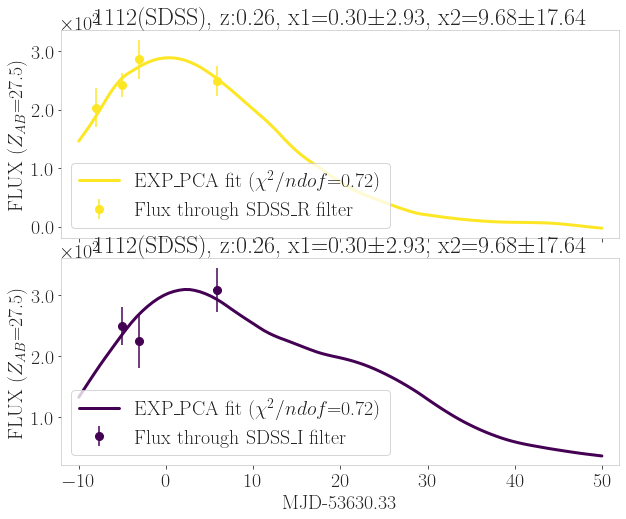

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


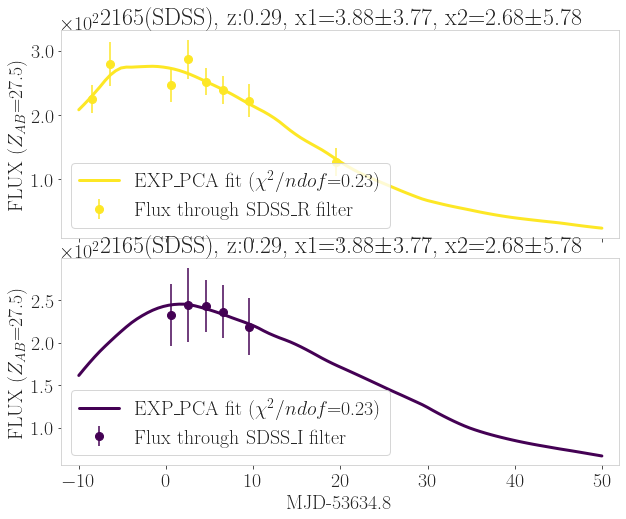

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


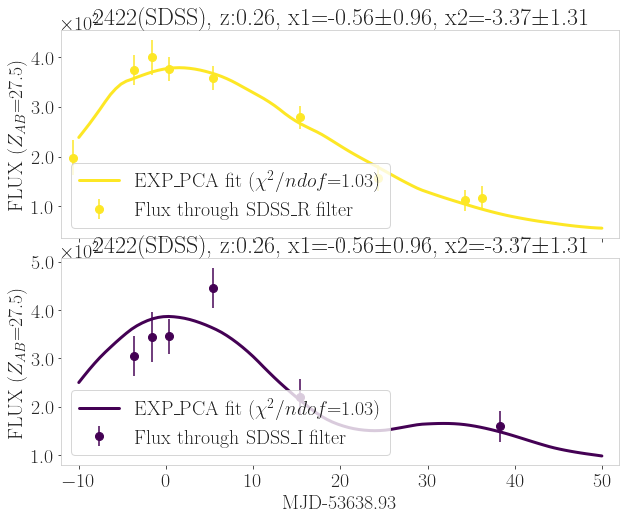

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


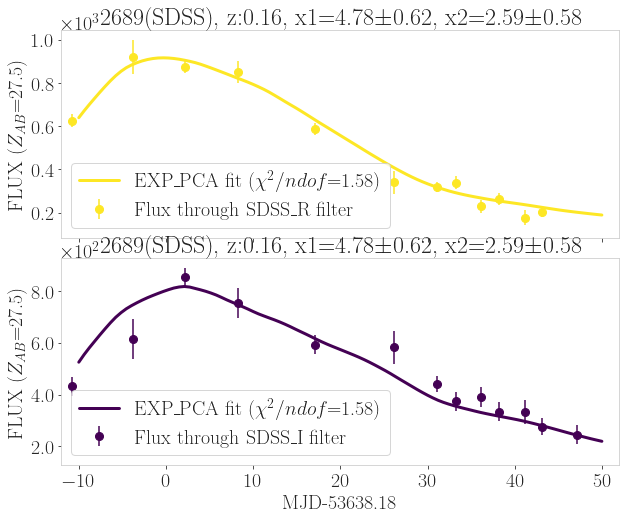

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


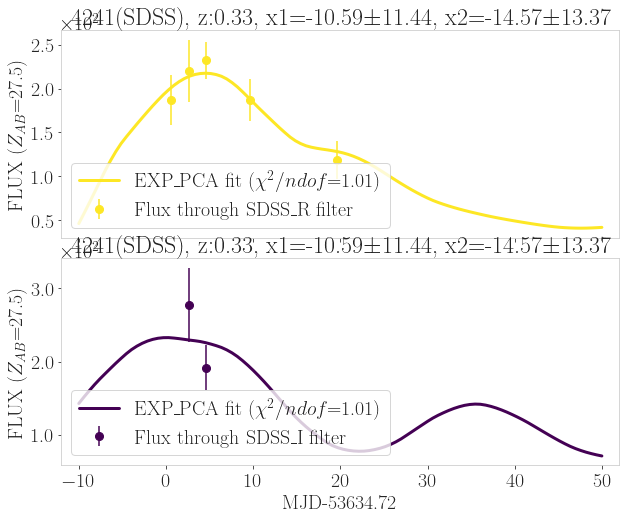

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


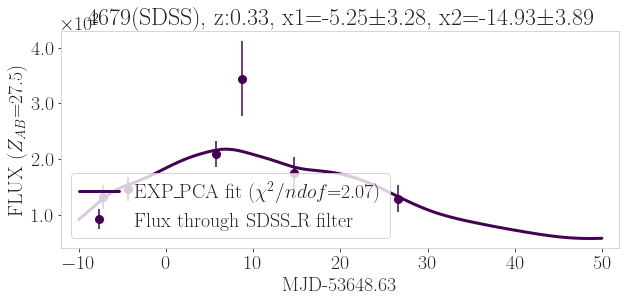

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


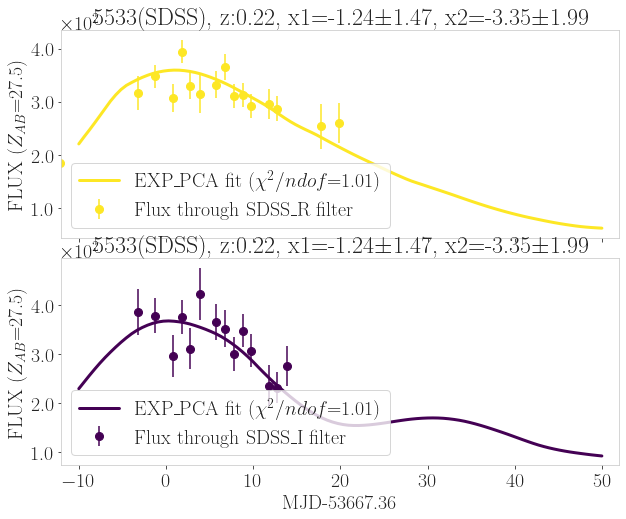

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


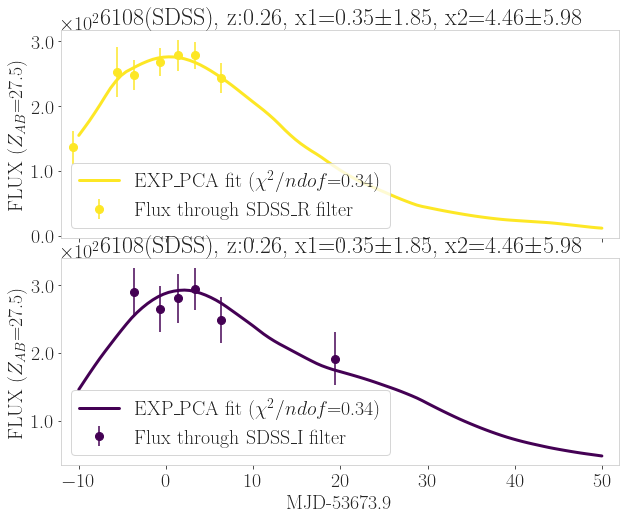

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


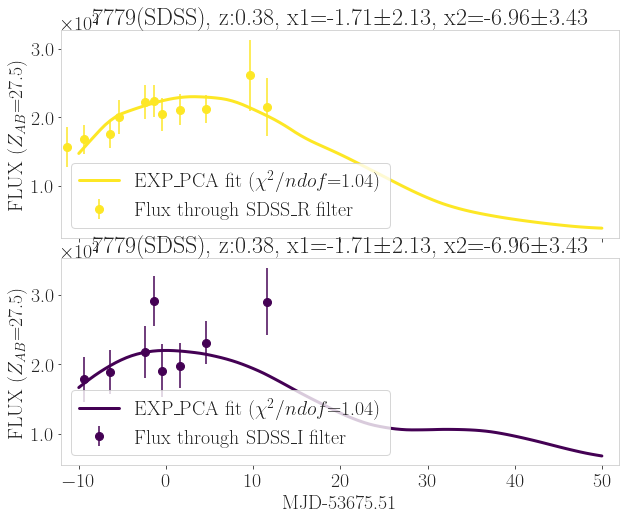

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


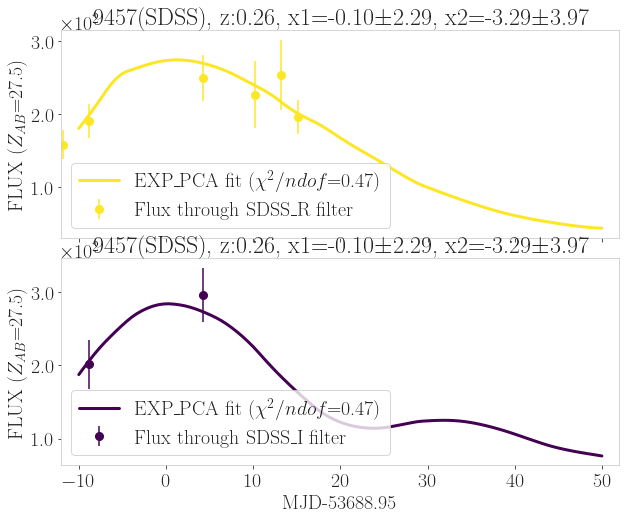

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


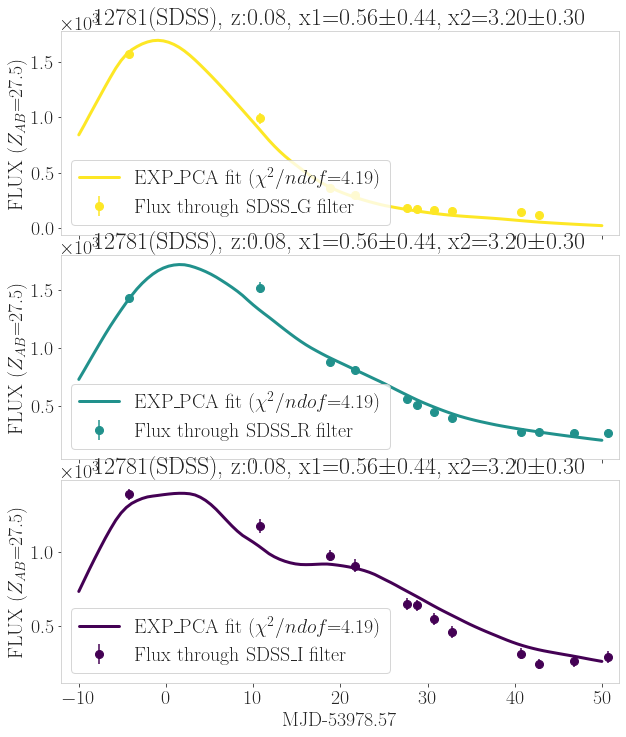

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(ou

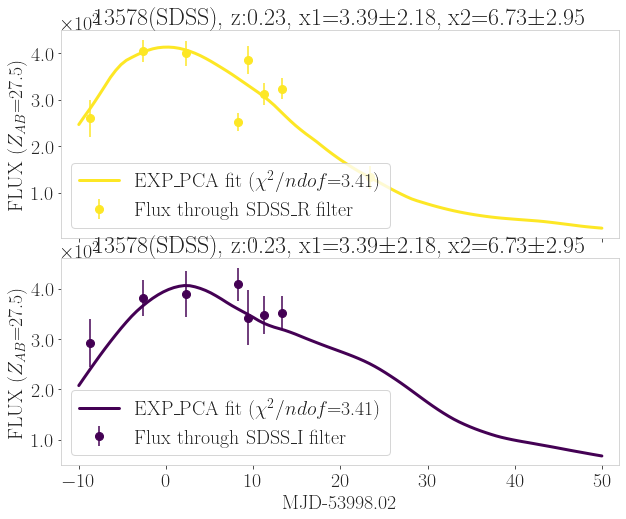

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


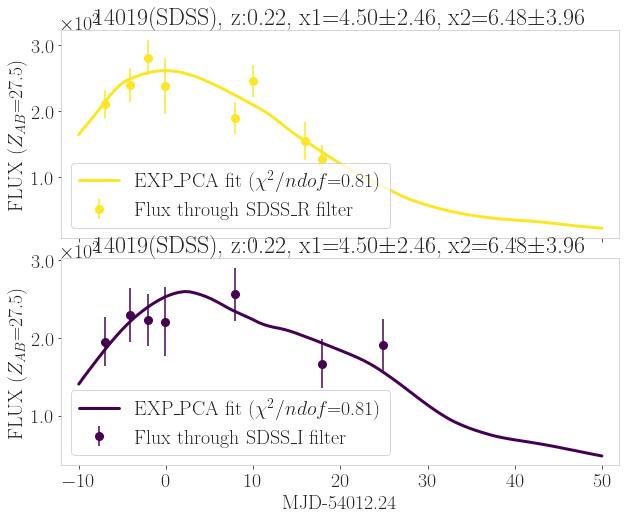

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


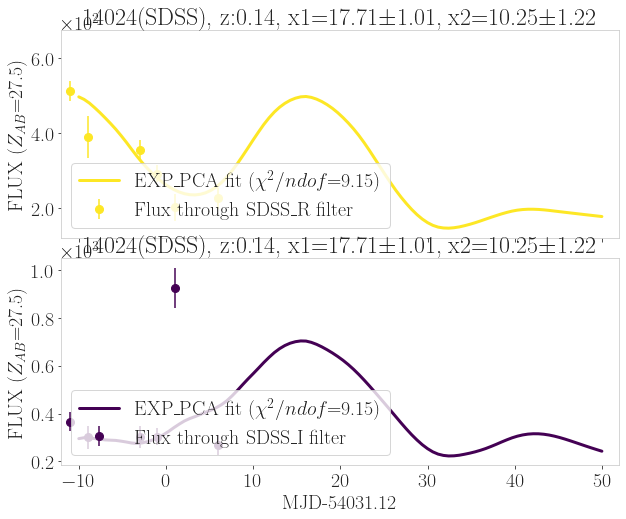

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


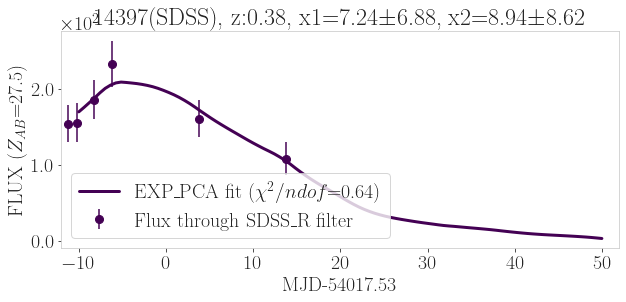

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


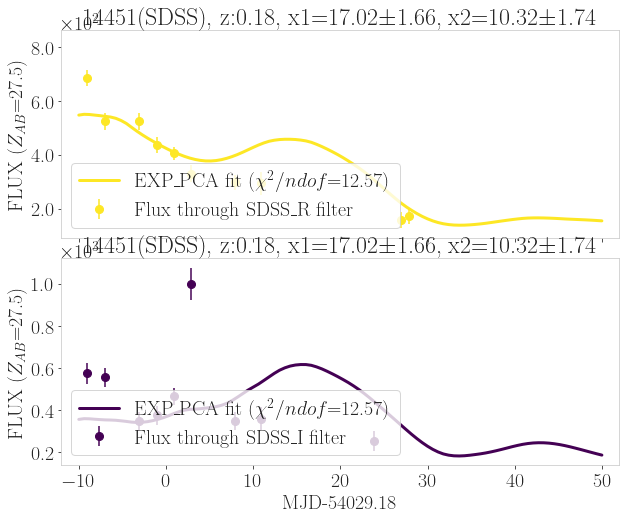

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


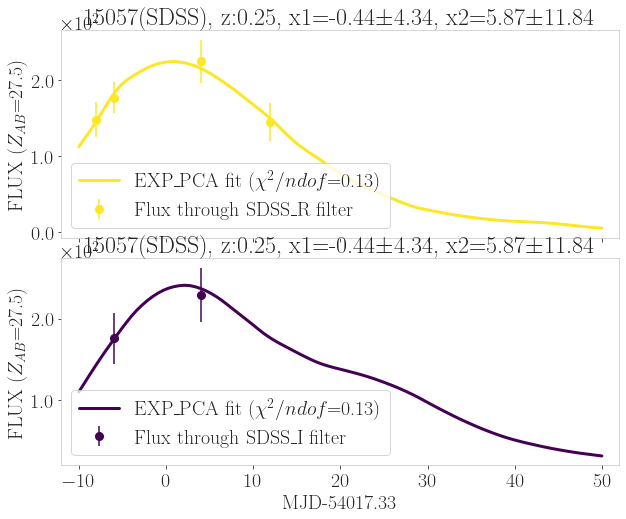

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


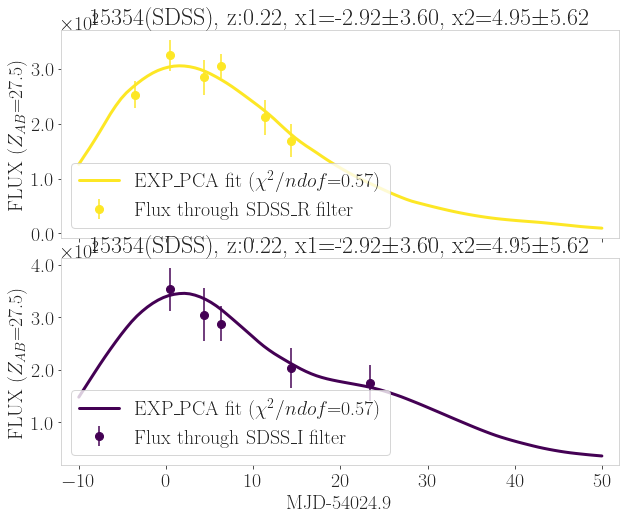

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


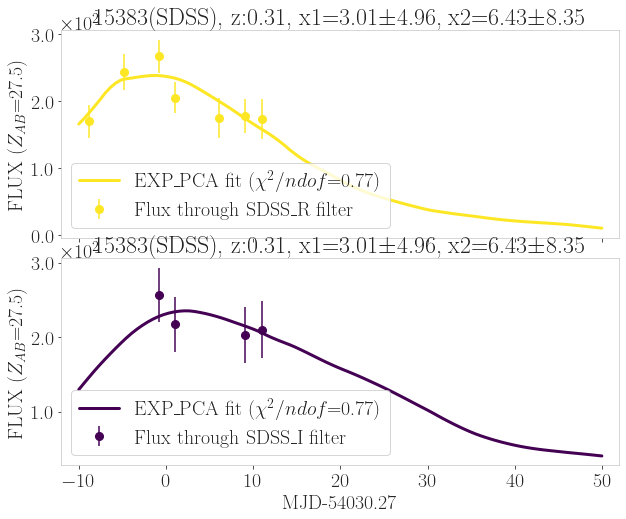

SN 15440 fit returns NaN
SN 15440 fit returns NaN



/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


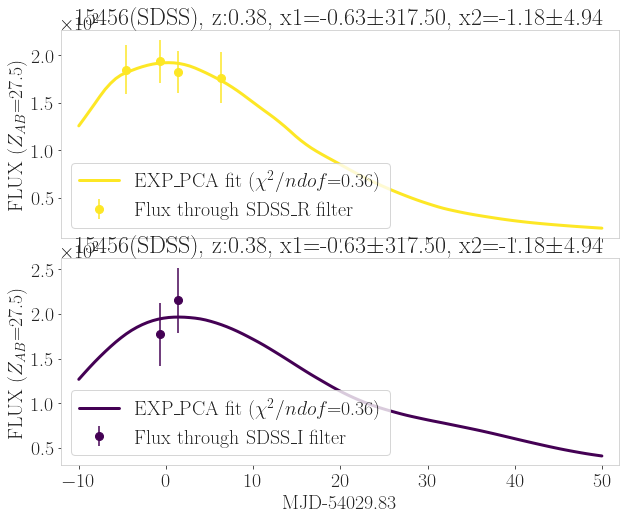

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


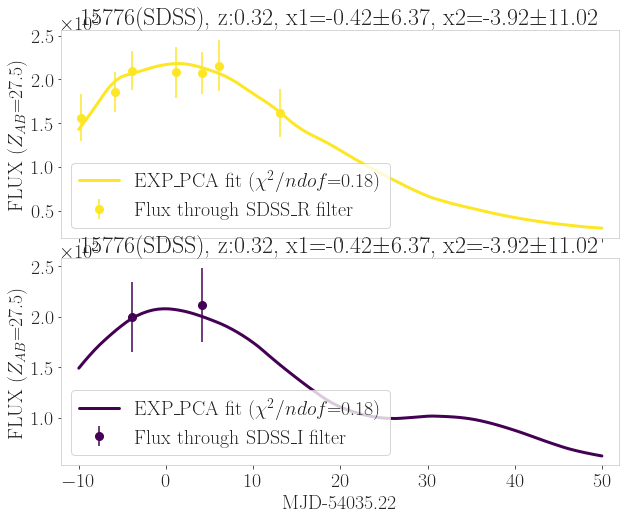

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


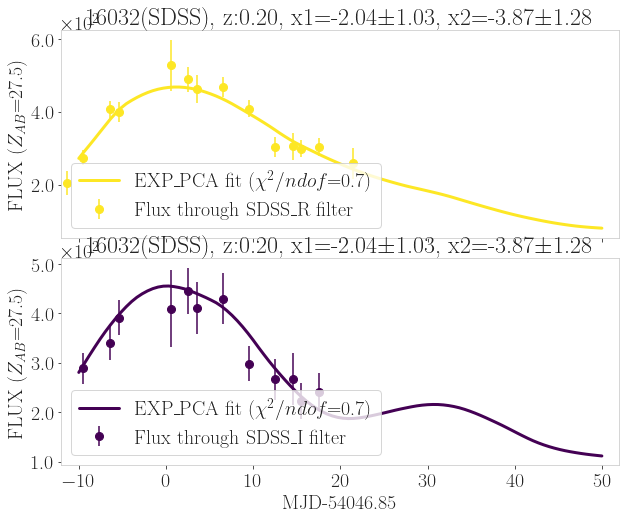

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


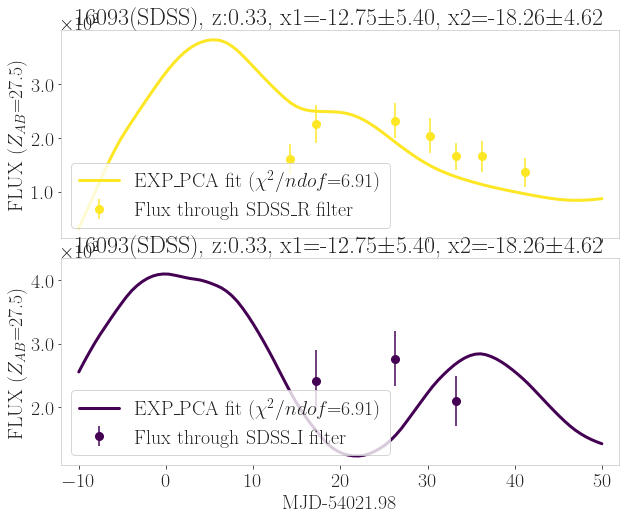

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


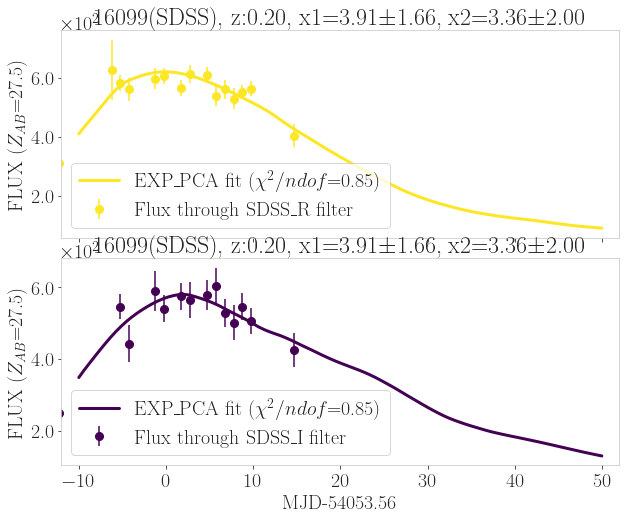

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


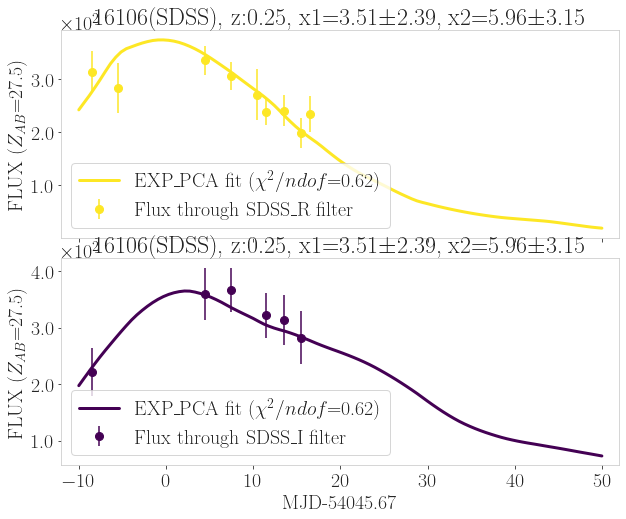

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


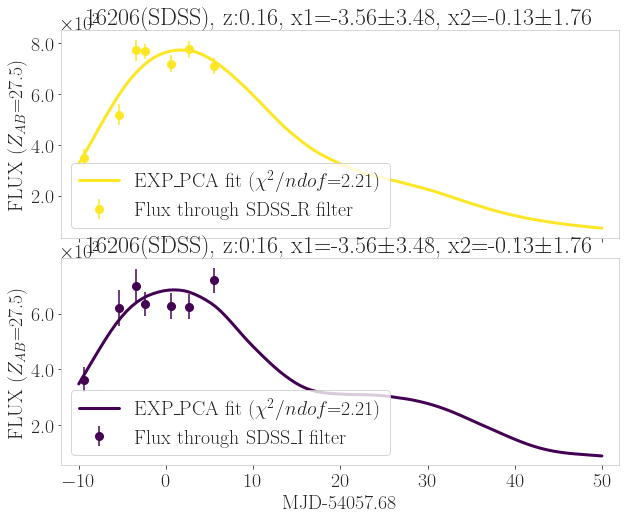

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


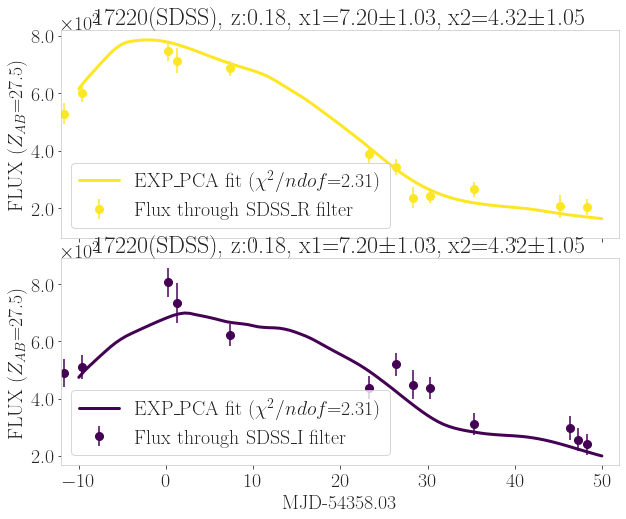

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


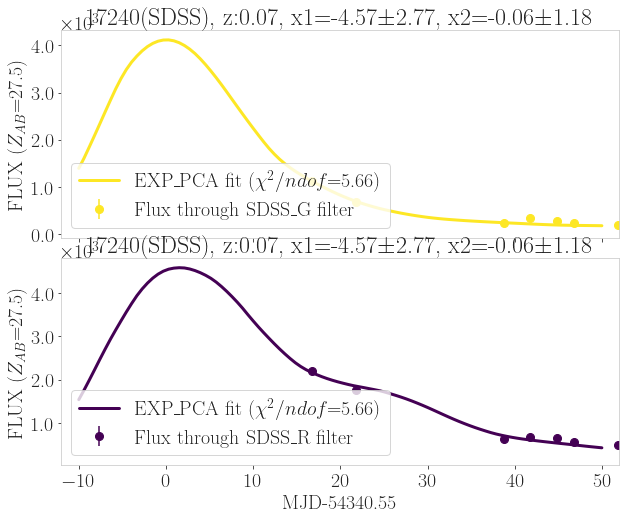

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


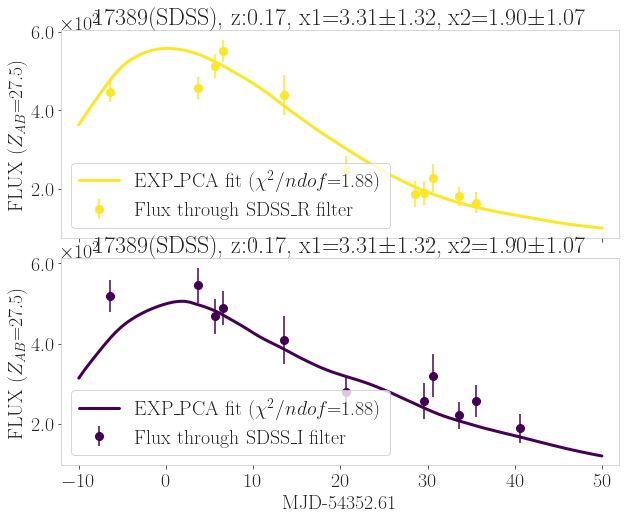

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


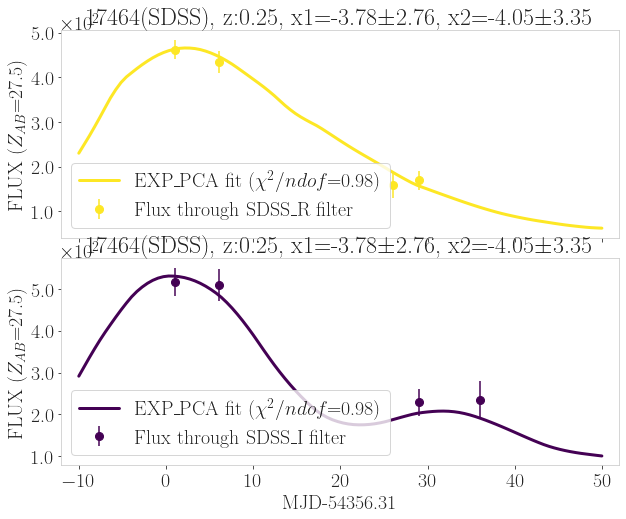

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


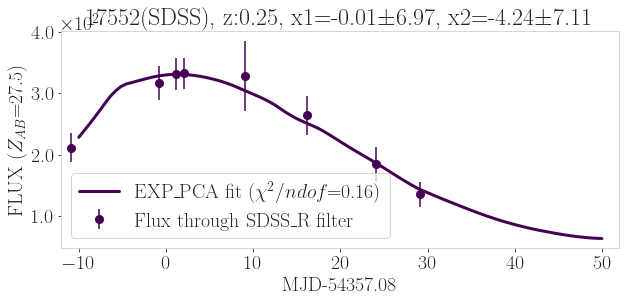

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


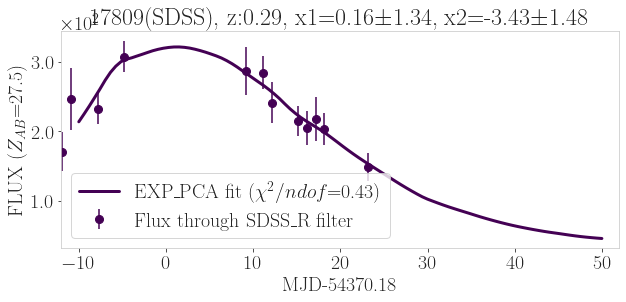

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


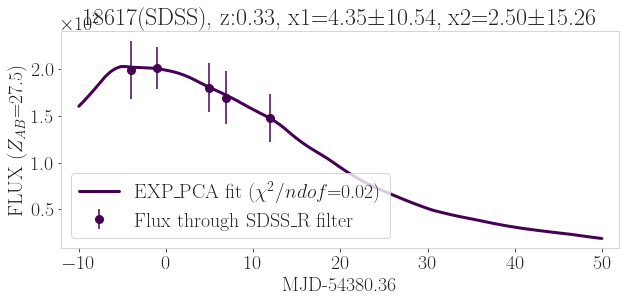

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


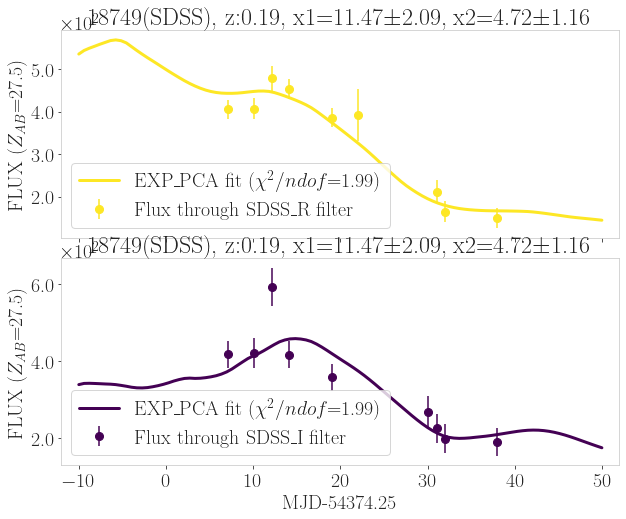

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(ou

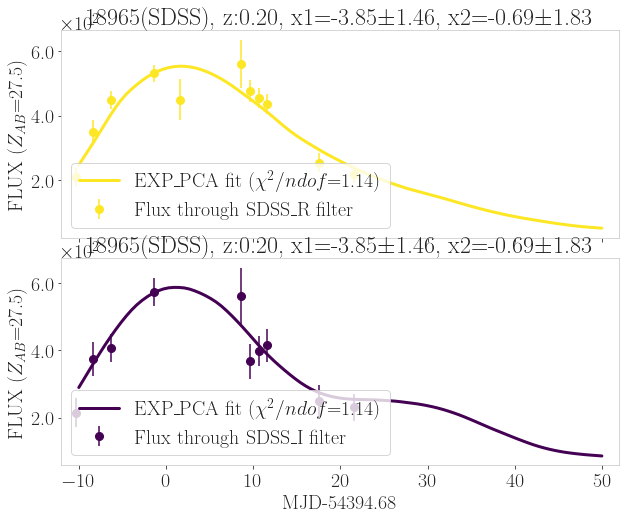

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


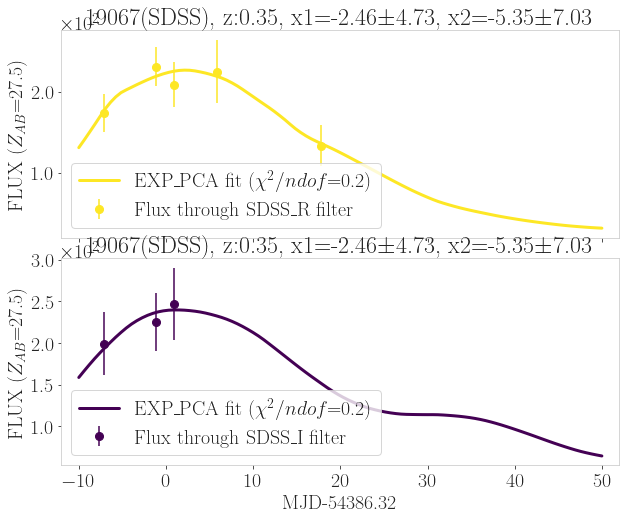

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


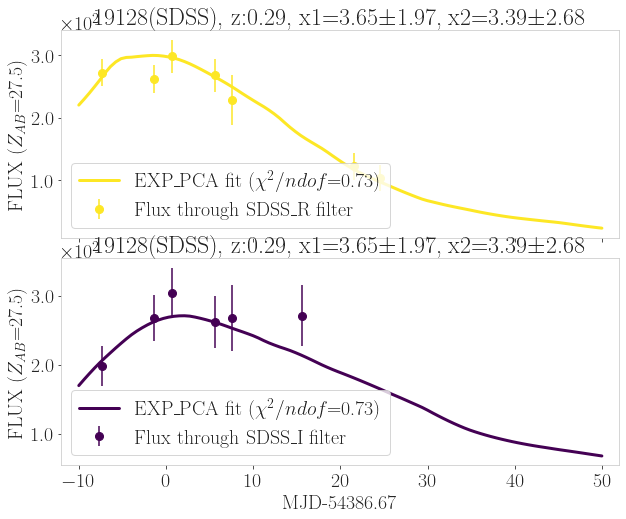

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


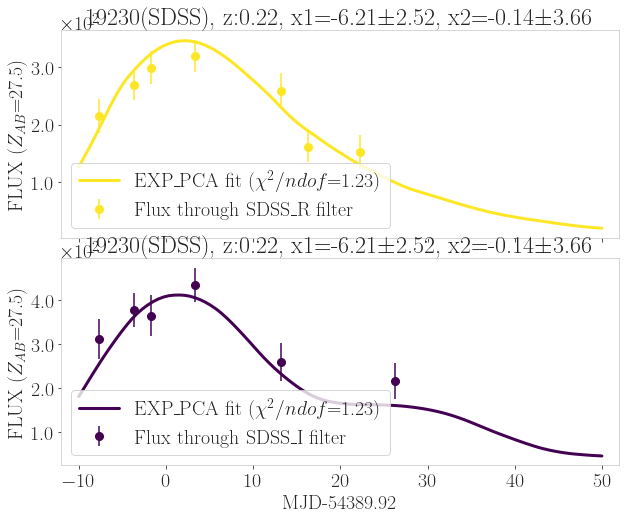

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: S

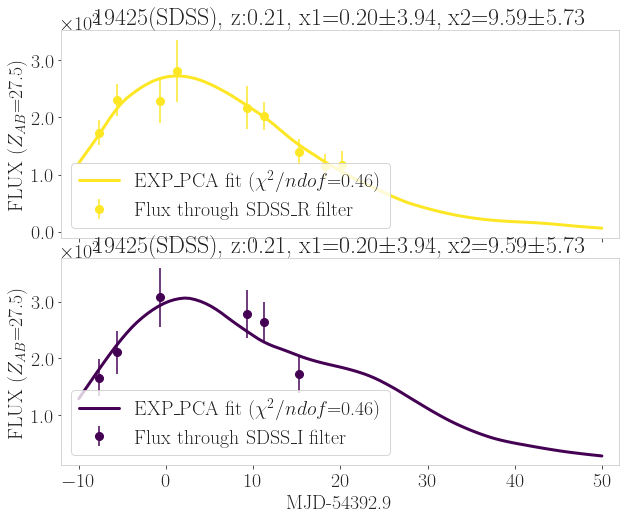

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


SN 20088 fit returns NaN
SN 20088 fit returns NaN



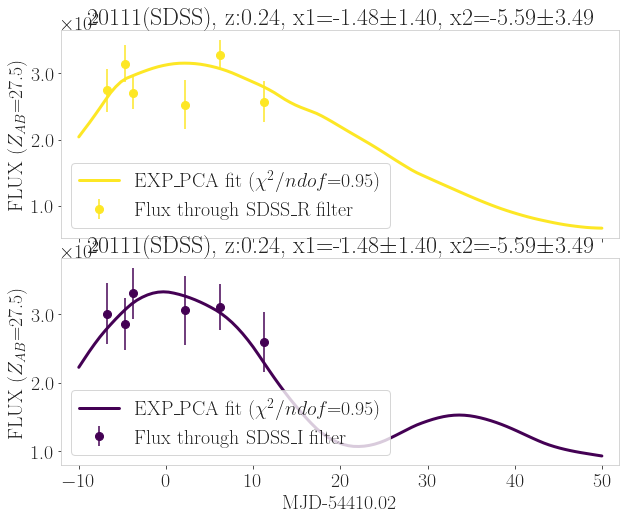

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


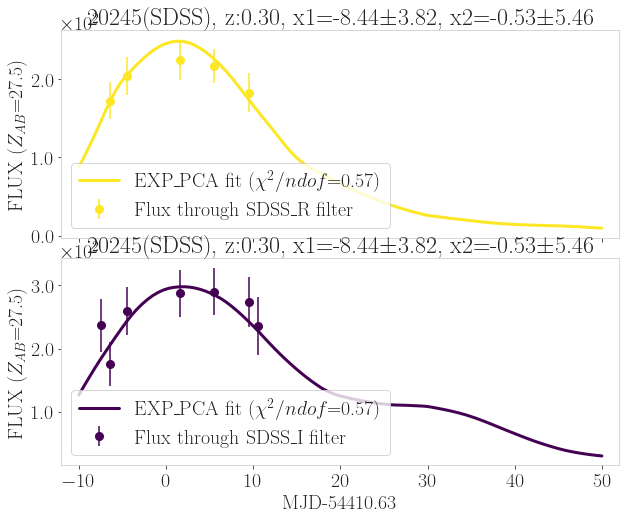

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


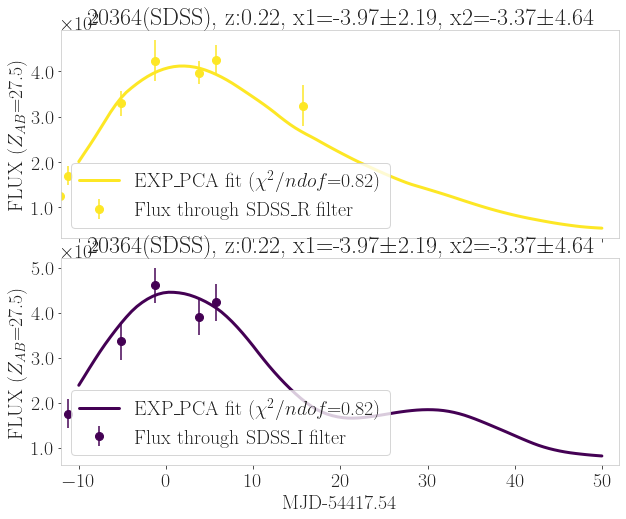

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


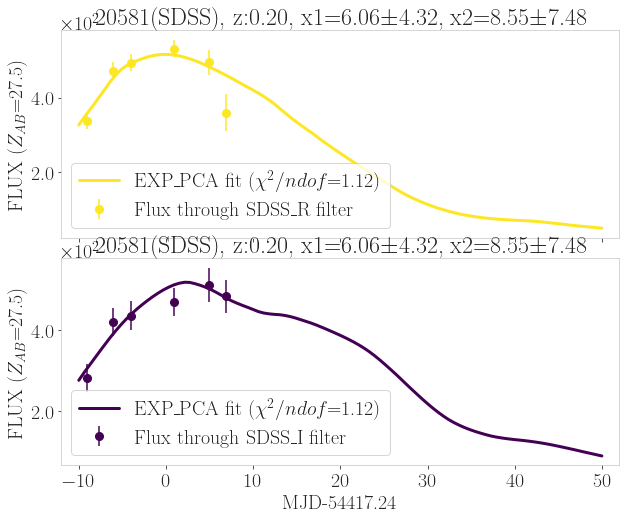

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


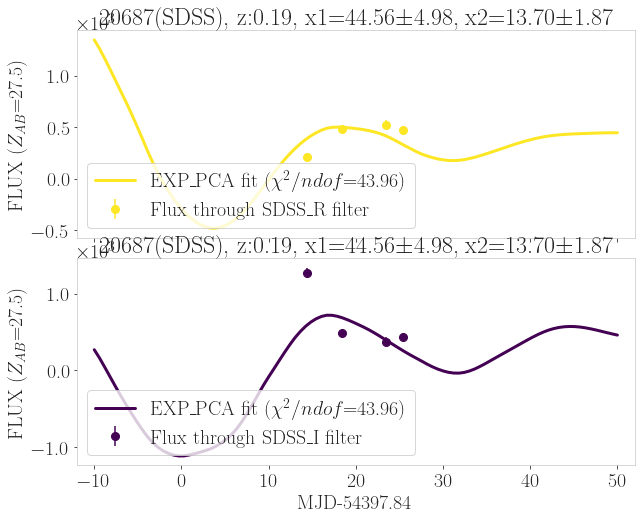

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


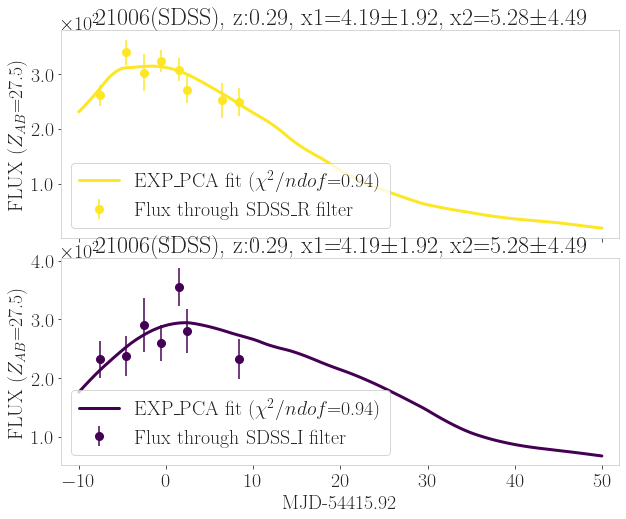

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


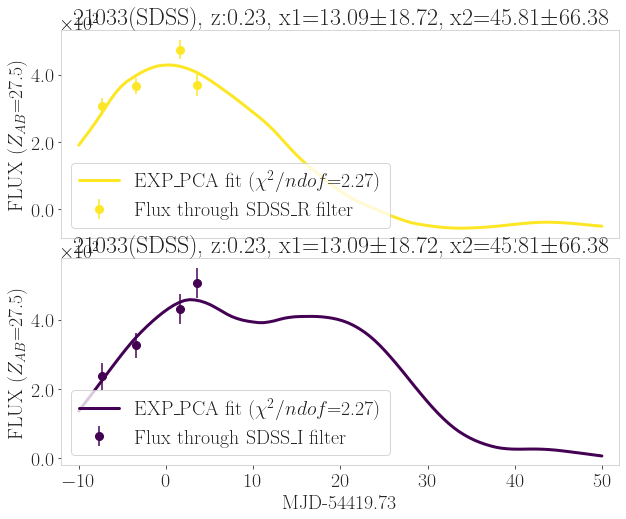

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


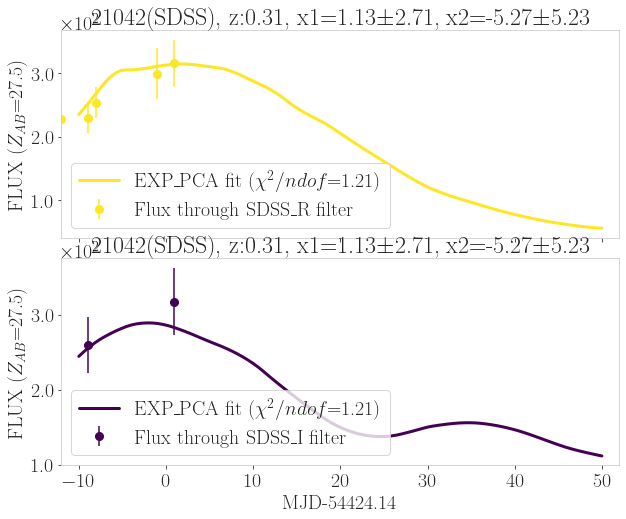

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


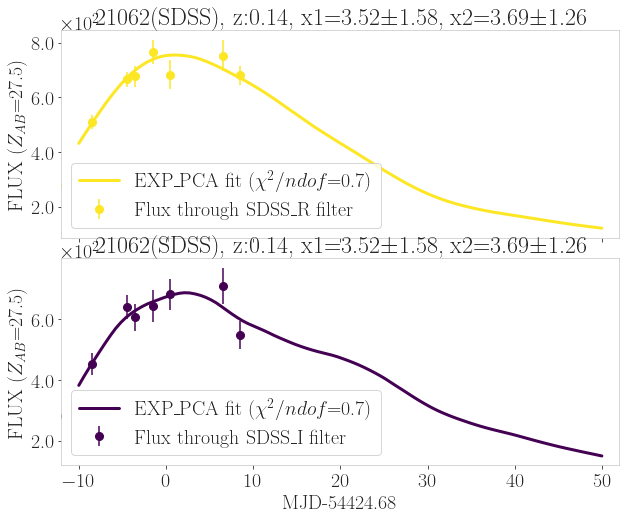

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


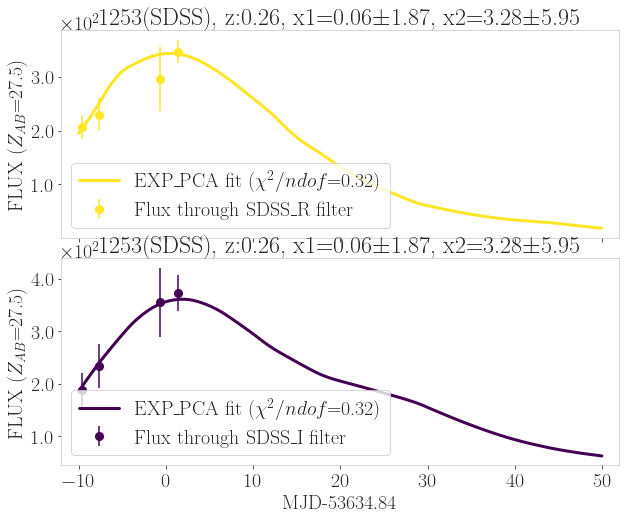

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


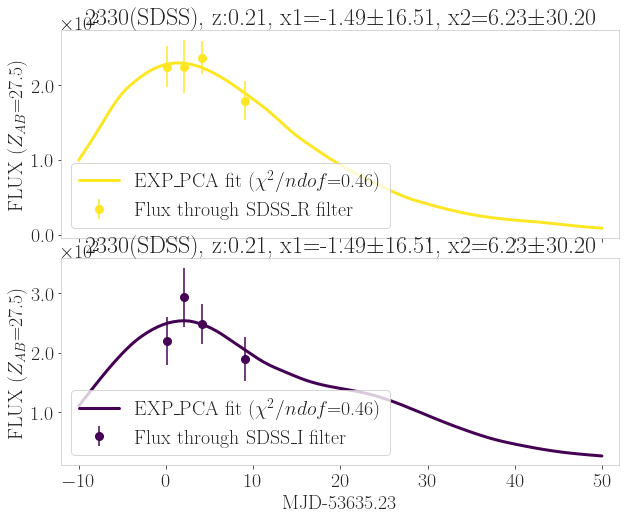

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


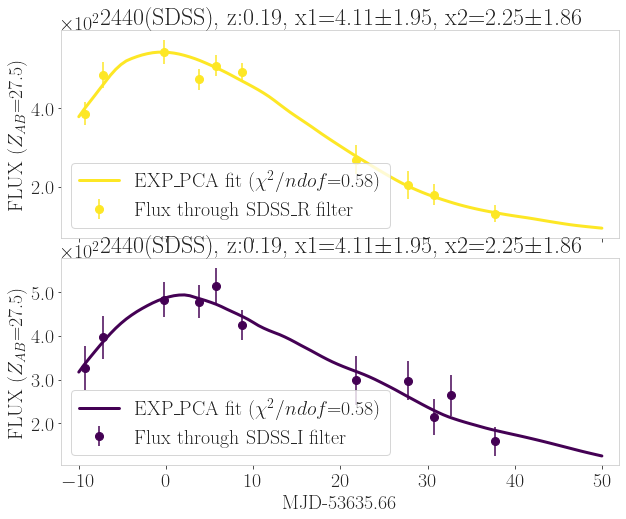

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


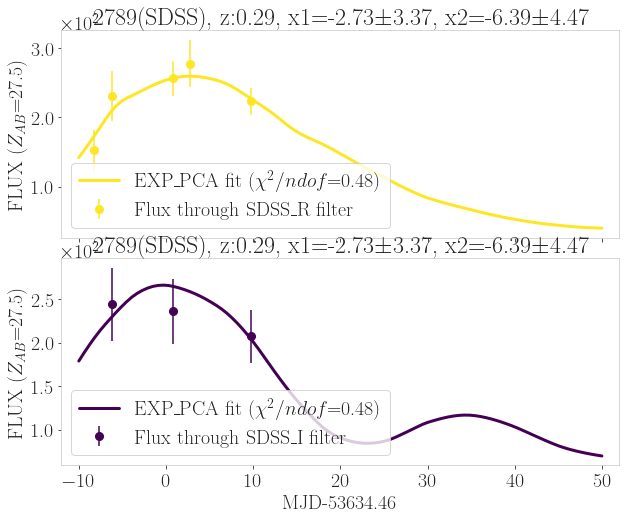

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


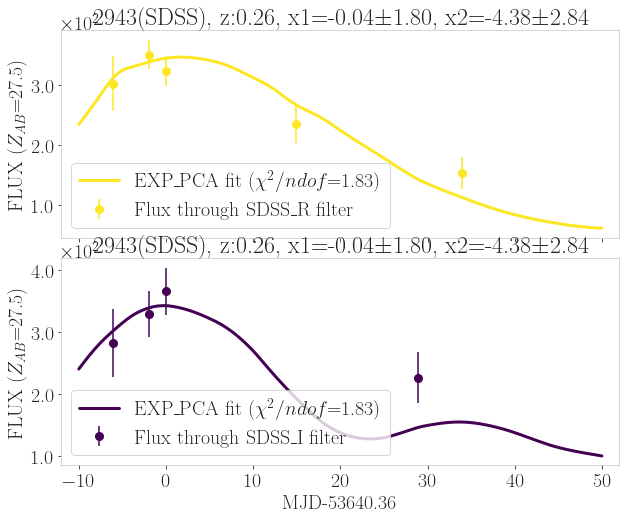

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(ou

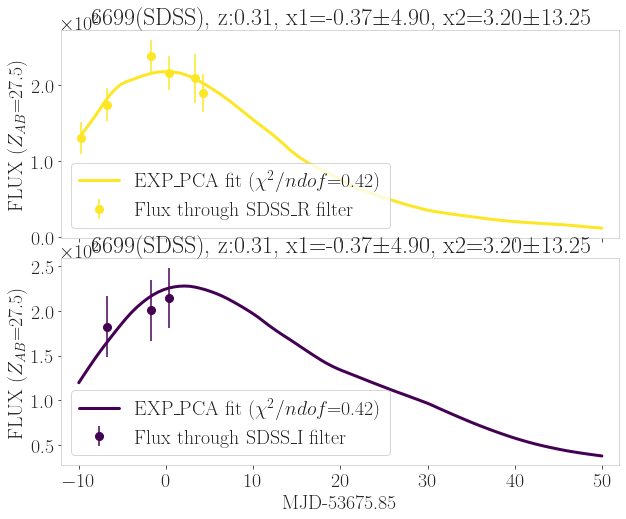

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


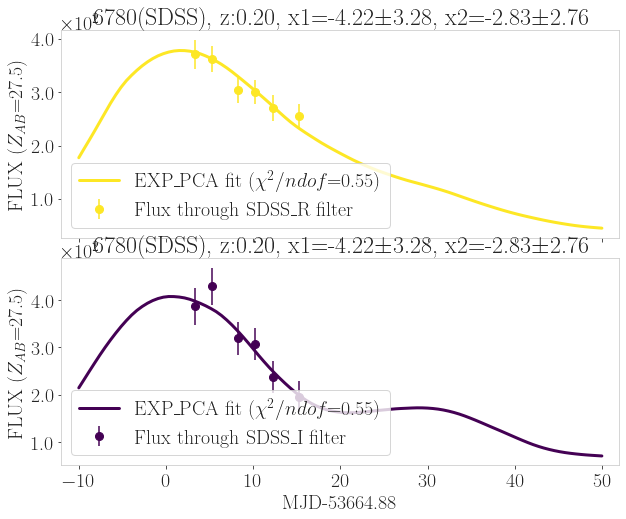

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


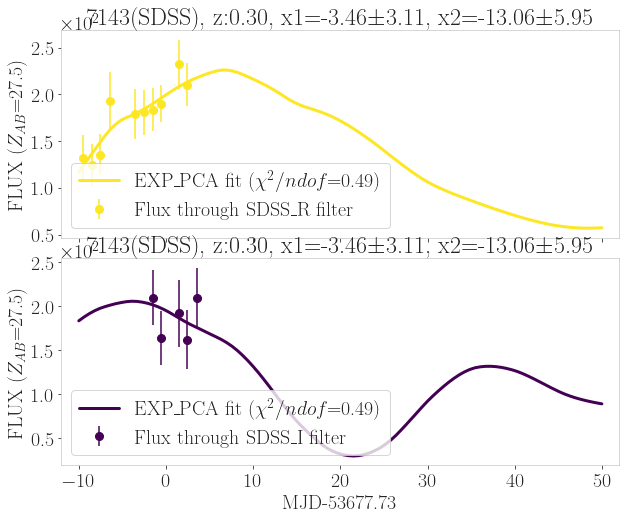

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


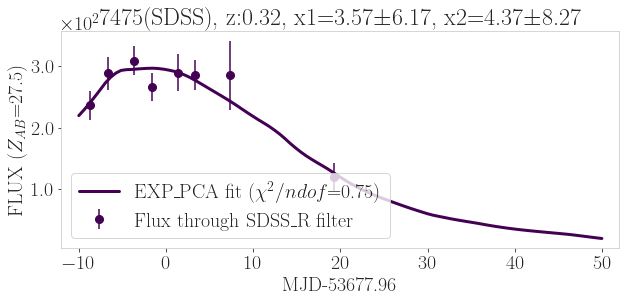

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


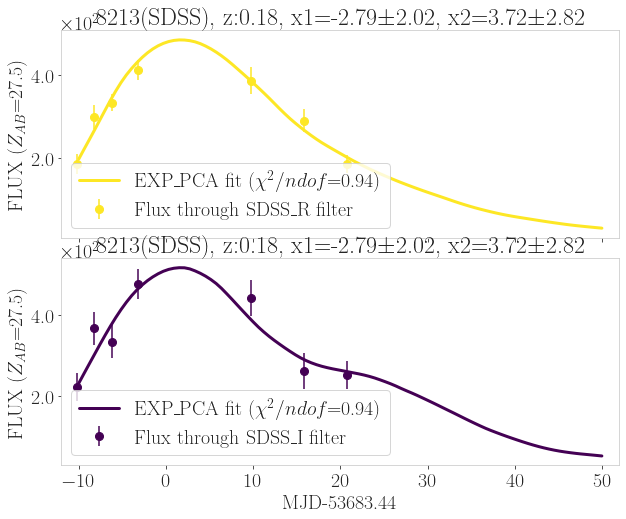

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


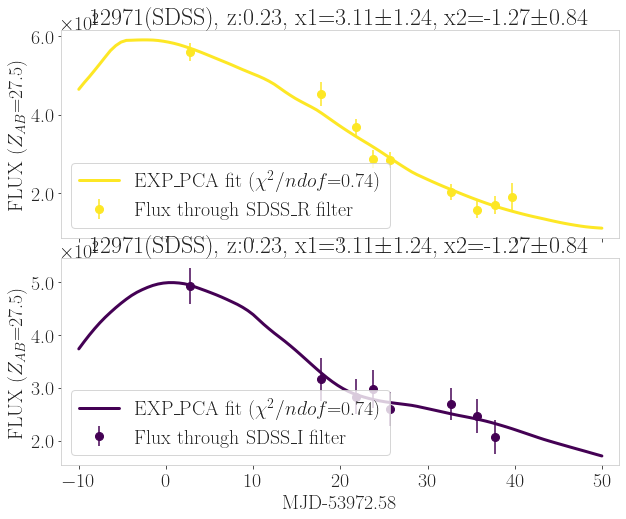

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


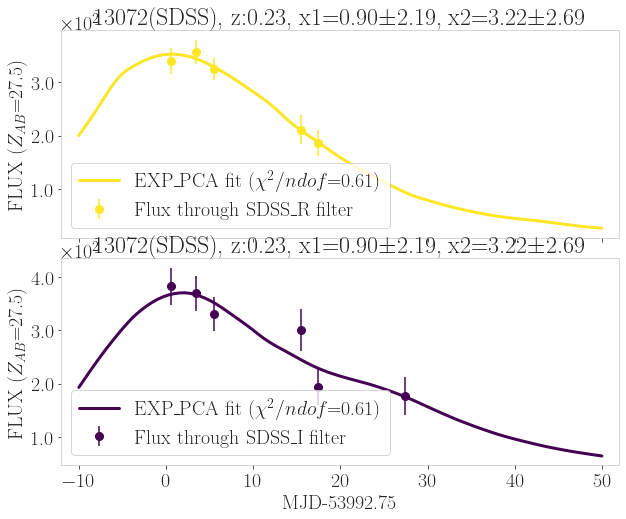

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


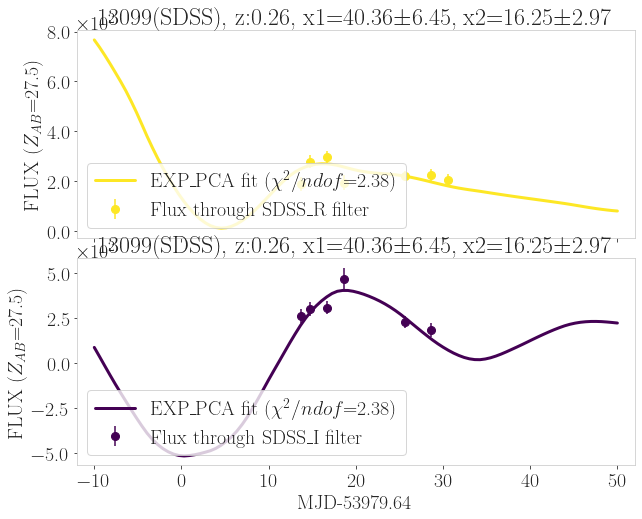

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


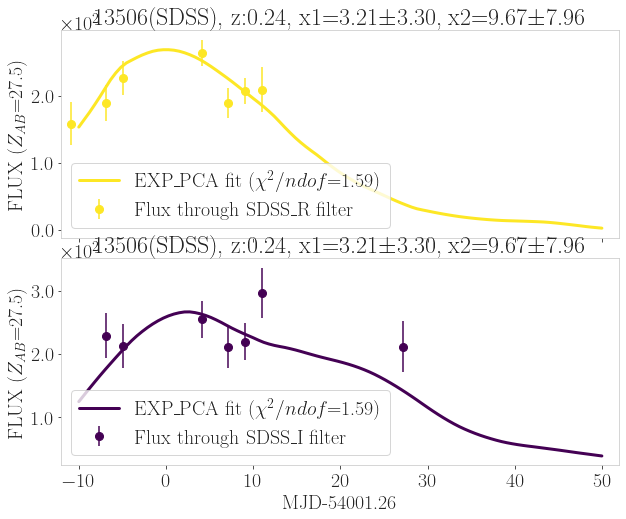

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


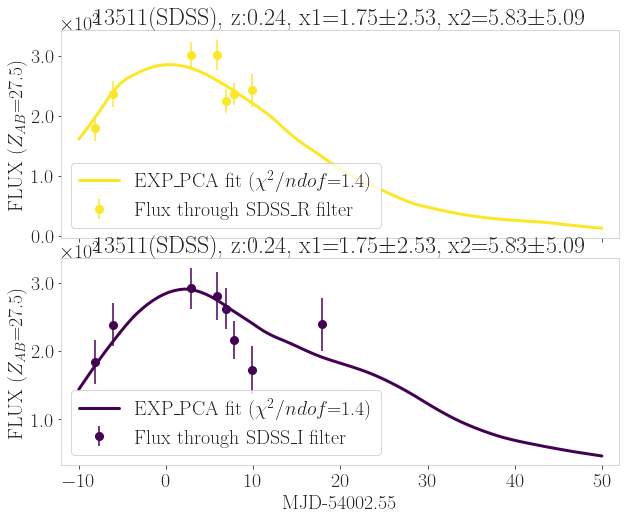

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


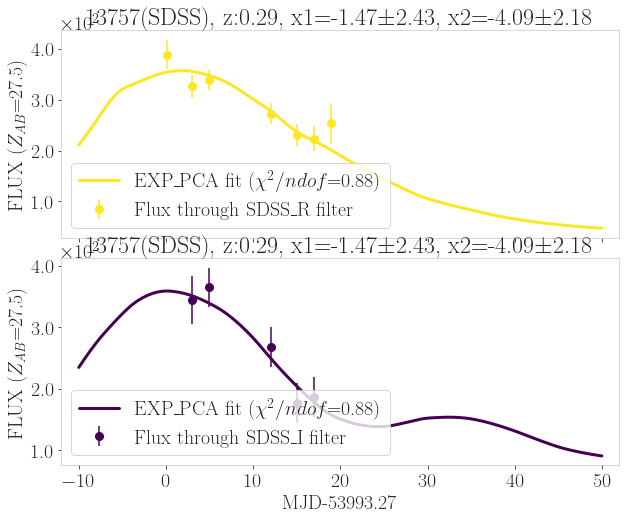

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


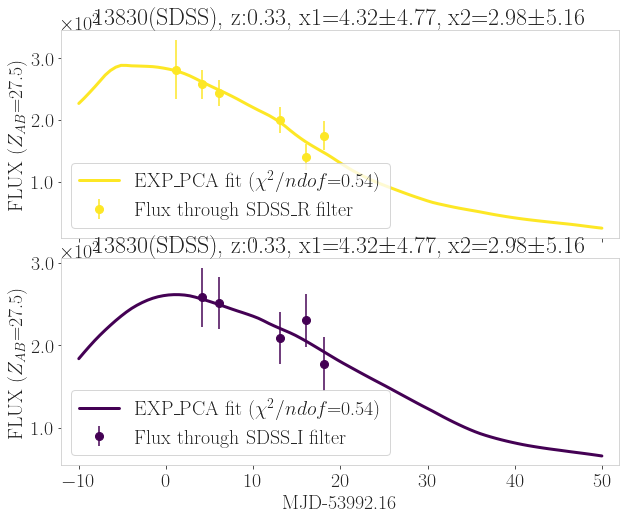

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


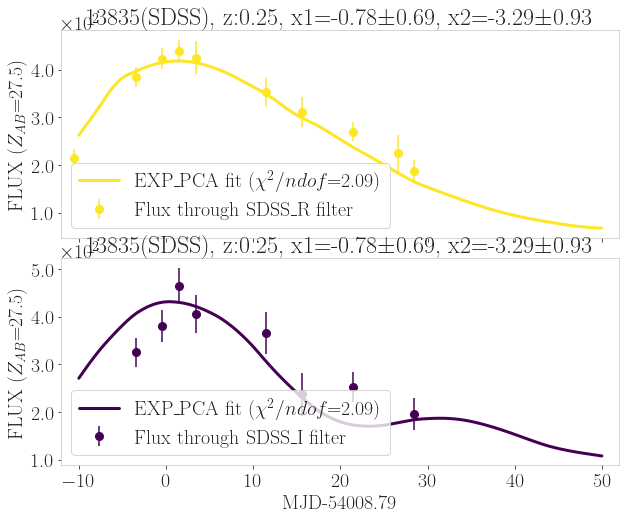

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


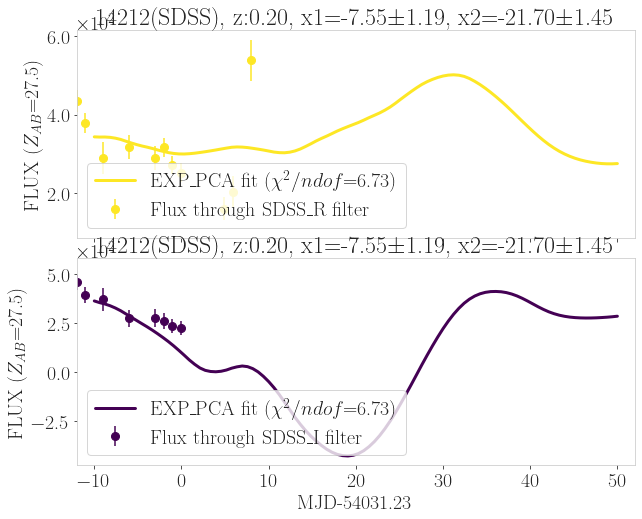

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


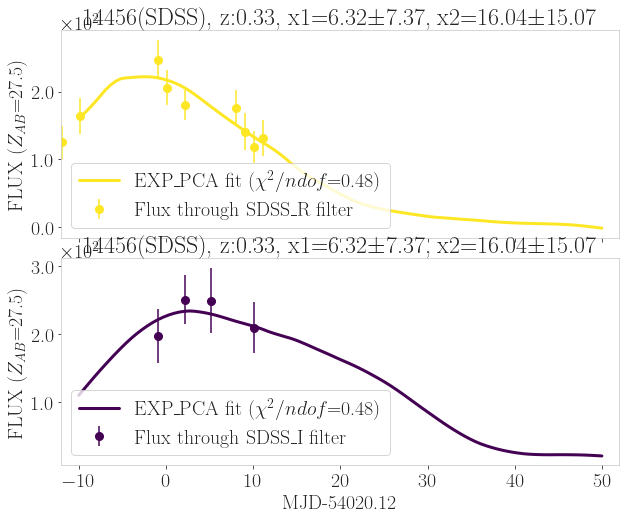

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


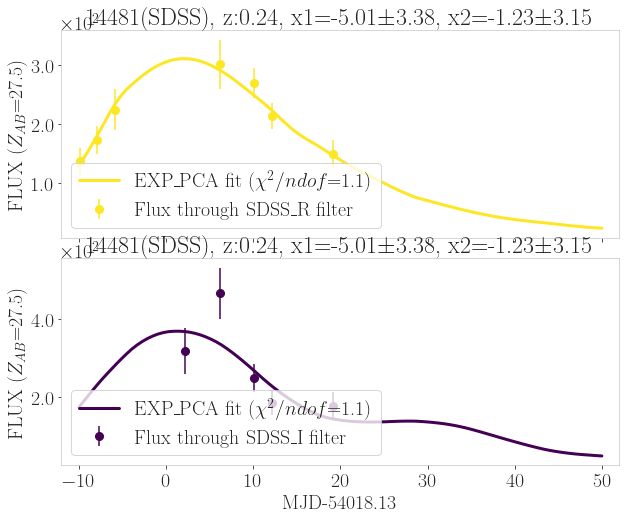

SN 14984 fit returns NaN
SN 14984 fit returns NaN



/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


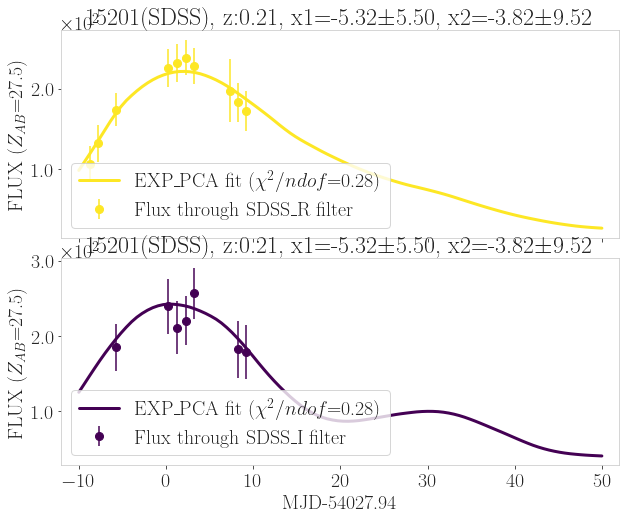

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


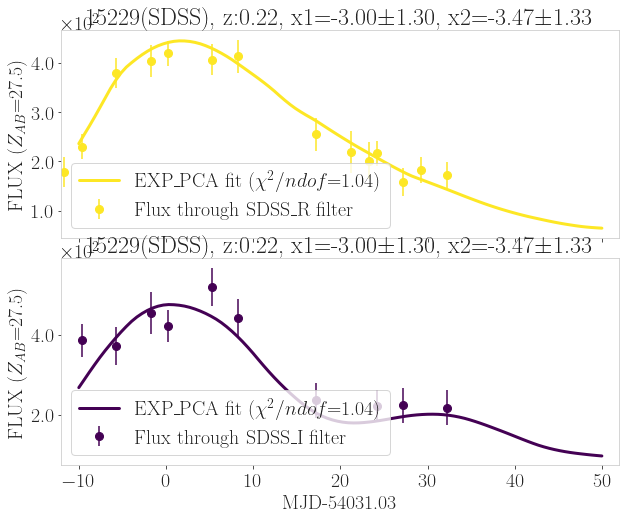

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


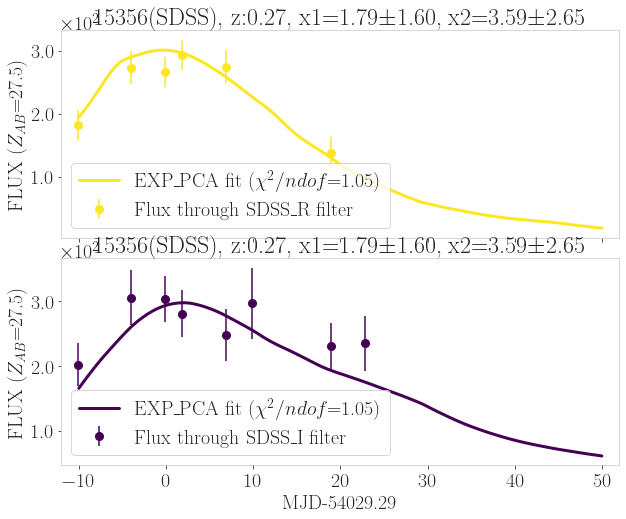

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U, SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


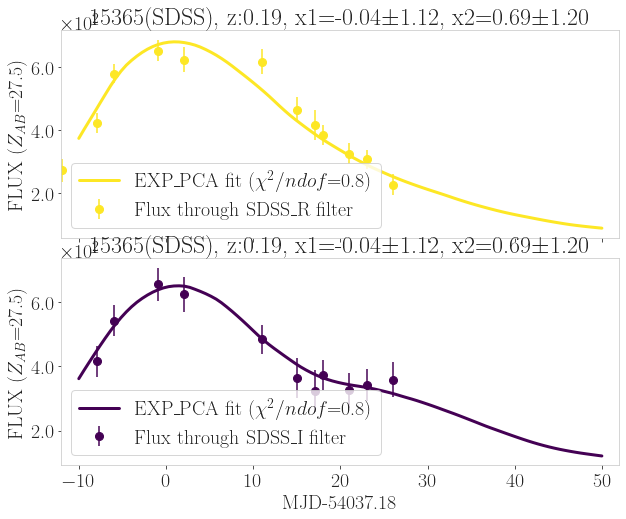

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


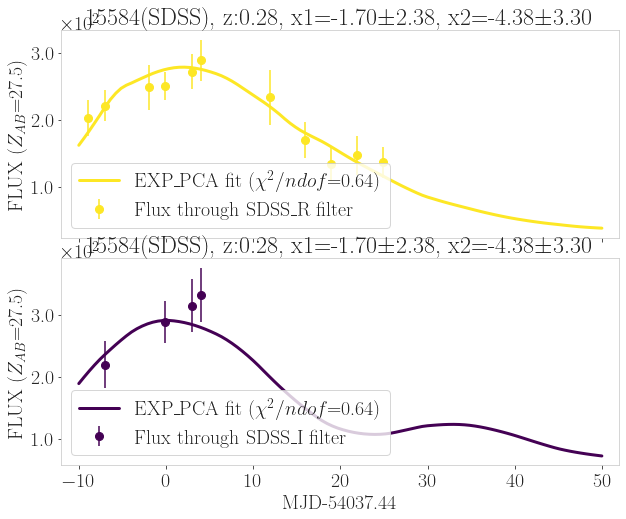

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


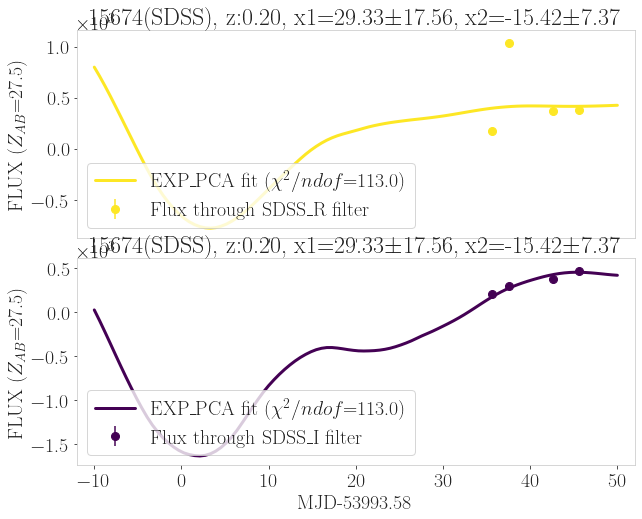

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


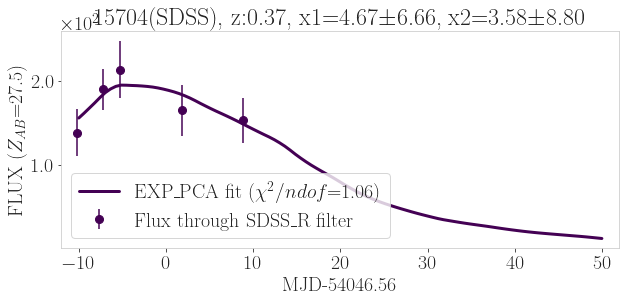

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


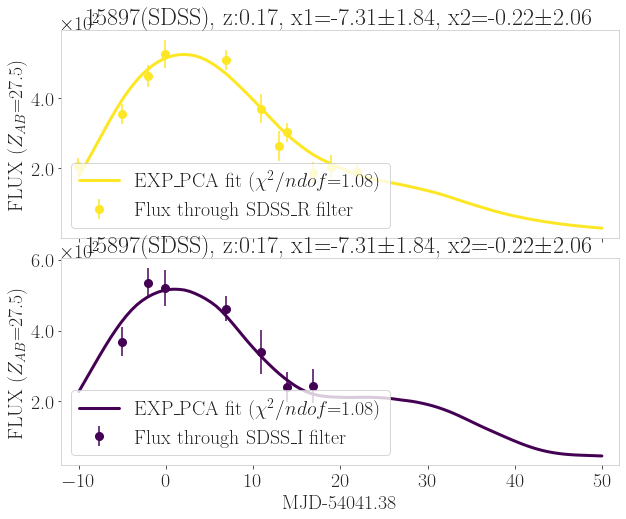

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


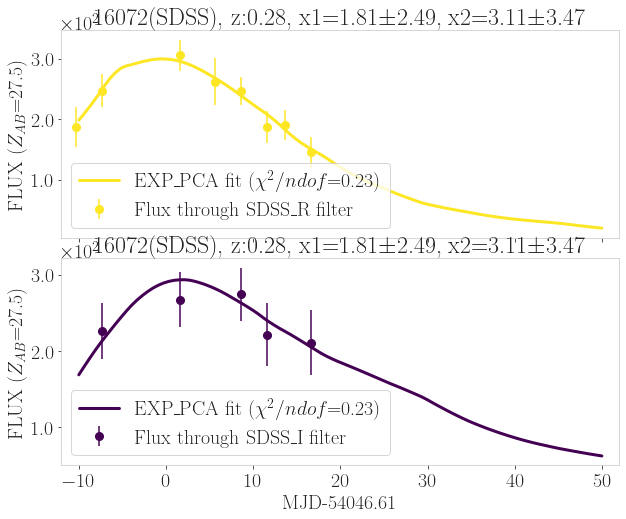

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


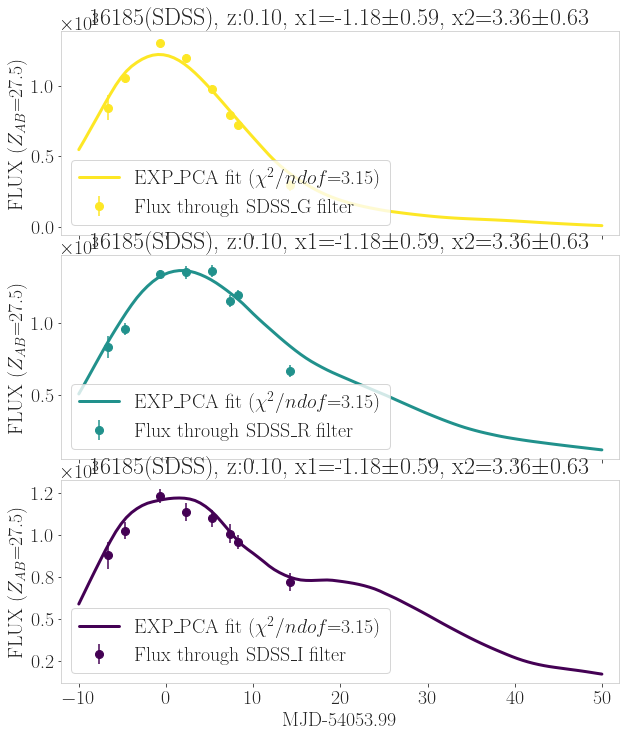

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


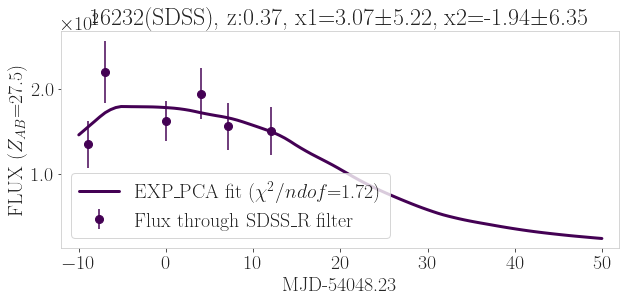

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


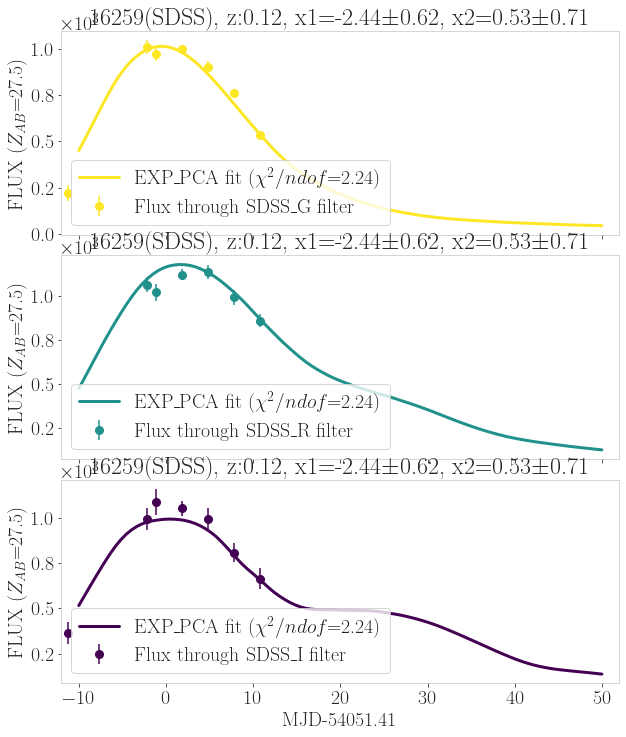

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


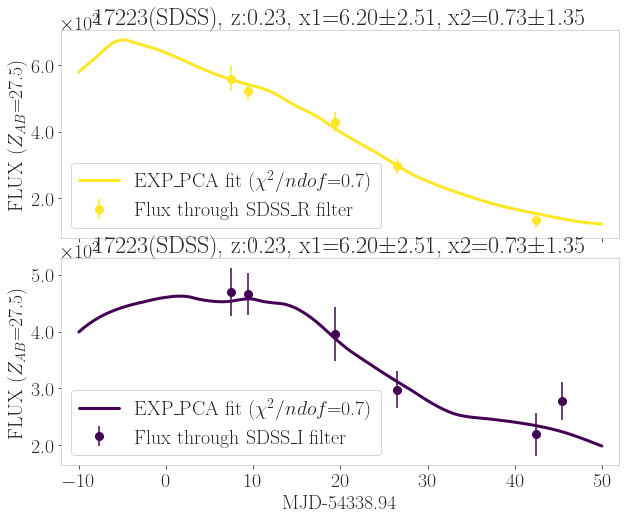

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


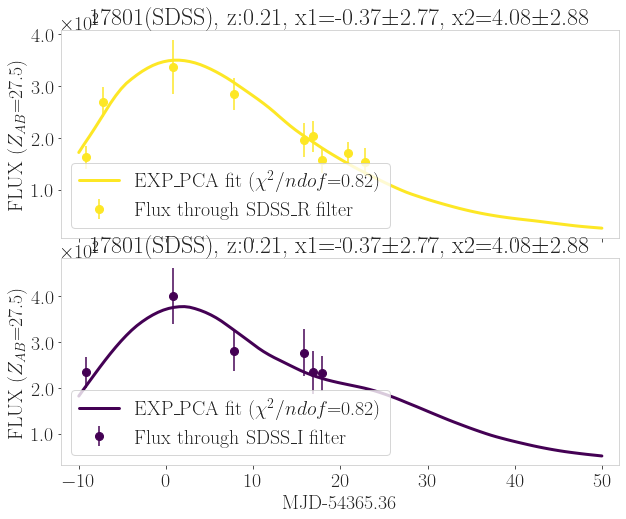

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


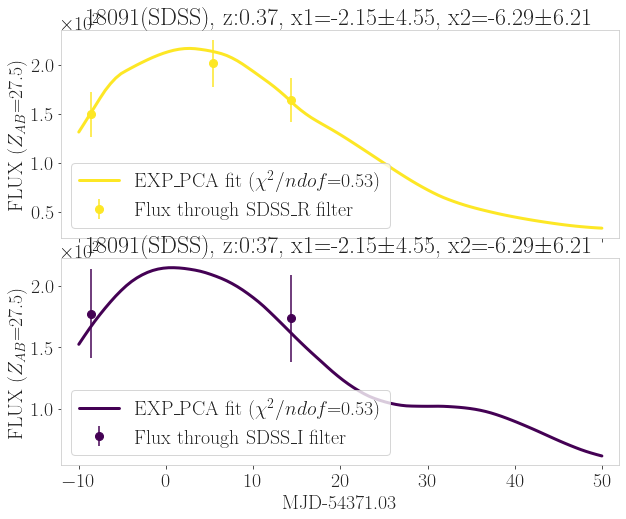

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


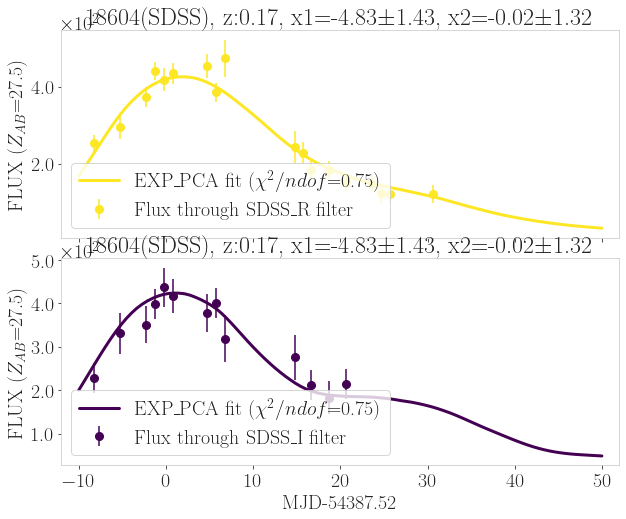

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


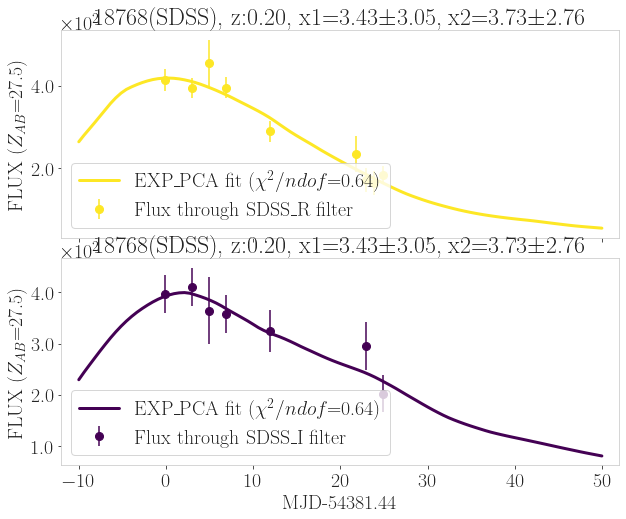

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


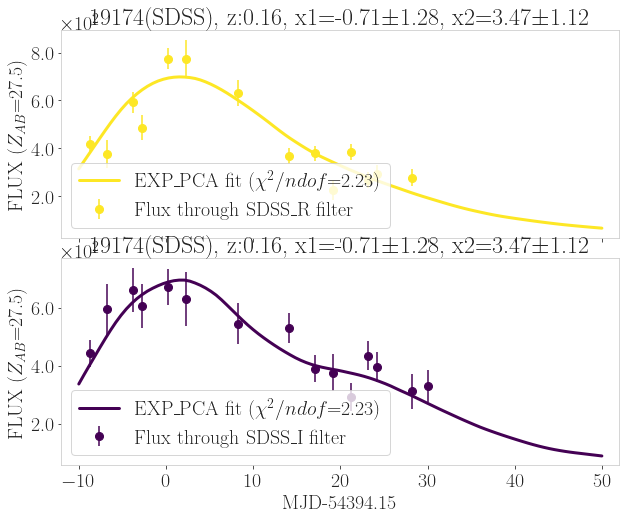

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


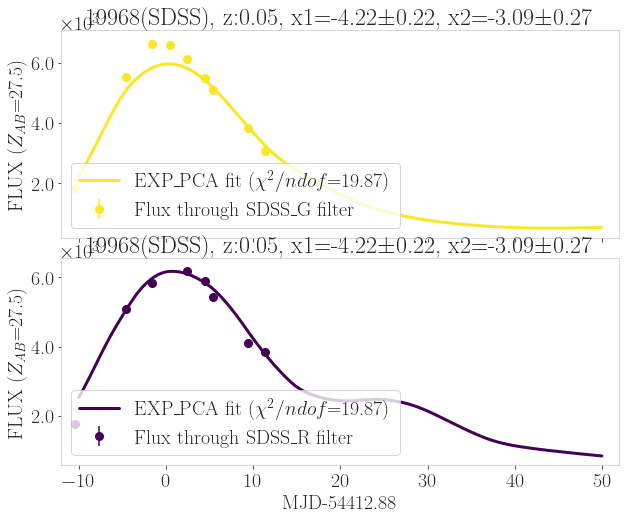

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


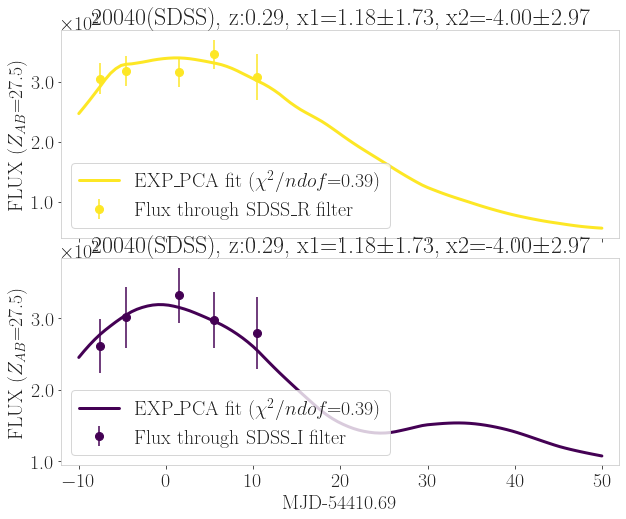

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


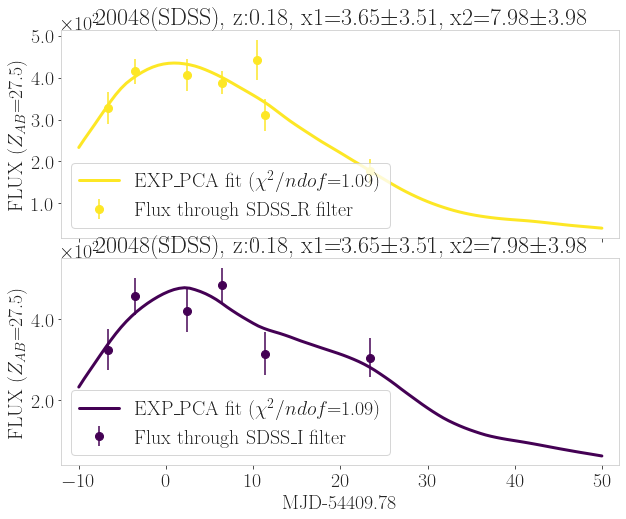

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


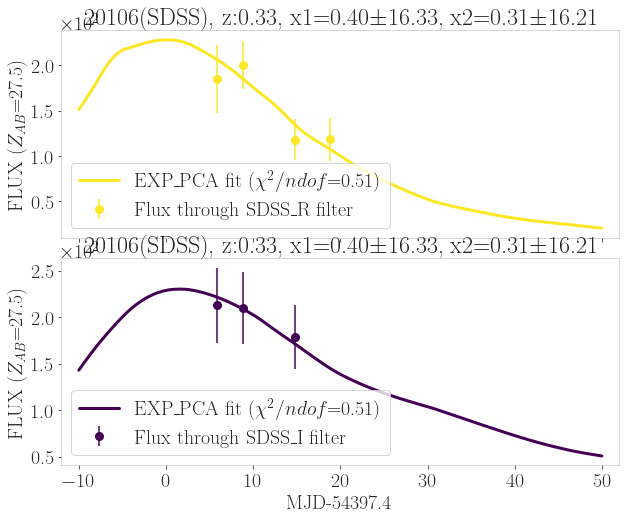

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_G(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


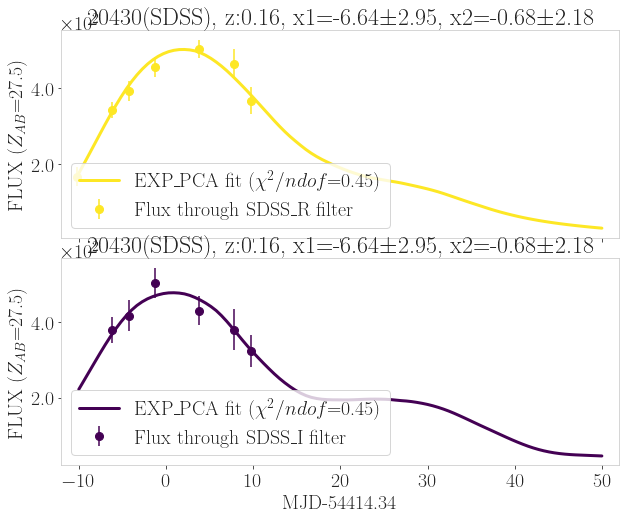

File not found for SN 2008050
SN 2008050 failed
File not found for SN 2008051
SN 2008051 failed


In [35]:
for j,sn in enumerate(sne_list):
    if sn not in pass_cosm_cuts:
        
        try:
            meta, surv, dat, result, fitted_model=lc_fit(sn) 
        except:
            print(f"SN {sn} failed")
            continue
            
        
        if result is None:
            print(f"SN {sn} fit returns NaN\n")
            continue
        
        lc_fit_plot(sn, surv, dat, result, fitted_model)     